In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer
import pickle
import logging
import sys
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import json
import re

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # When cudnn implementation not found, run this
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Note: when starting kernel, for gpu_available to be true, this needs to be run
# only reserve 1 GPU
os.environ['TFHUB_CACHE_DIR'] = '/home/anasab/tf_cache'


In [3]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# # confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
# from keras import backend
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# # confirm PyTorch sees the GPU
# from torch import cuda
# assert cuda.is_available()
# assert cuda.device_count() > 0
# print(cuda.get_device_name(cuda.current_device()))

/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anasab/tf2conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11305799109130634554,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14461666012902459528
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7831709287
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 882650986324403272
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 33926571032134383
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Lambda, BatchNormalization, TimeDistributed, \
    Bidirectional, Input, concatenate, Flatten, RepeatVector, Activation, Multiply, Permute, \
    Conv1D, GlobalMaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords

import tensorflow as tf


In [6]:
dataset_type = "depression"
transfer_type = None

In [7]:
logger = logging.getLogger('training')
ch = logging.StreamHandler(sys.stdout)
# create formatter
formatter = logging.Formatter("%(asctime)s;%(levelname)s;%(message)s")
# add formatter to ch
ch.setFormatter(formatter)
# add ch to logger
logger.addHandler(ch)
logger.setLevel(logging.DEBUG)

In [8]:
import sys
sys.setrecursionlimit(10000)

In [9]:
# tf.enable_eager_execution()
my_seed = 1234
# tf.set_random_seed(my_seed)

In [10]:
tf.test.is_gpu_available()

True

In [11]:
# from keras.backend import manual_variable_initialization 
# manual_variable_initialization(True)

# Read data

In [12]:
def read_subject_writings(subject_file):
    writings = []
    with open(subject_file) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text.strip()
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
    return writings

In [13]:
root_dir = '/home/anasab/' 
# root_dir = '/home/ana/'

### eRisk 2020 T1

In [14]:
# datadir_T1 = root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
# labels_file_T1 = root_dir + '/eRisk/data//eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

datadirs_T1_2020 = {
    'train': ['./data/'],
    'test': ['./DATA/']
}
datadir_root_T1_2020 = {
    'train': root_dir + '/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/',
    'test': root_dir + '/eRisk/data/2020/T1/'
}
    
labels_files_T1_2020 = {
    'train': ['golden_truth.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [15]:
def read_texts_2020(datadir_root_T1_2020,
                   datadirs_T1_2020,
                   labels_files_T1_2020,
                   test_suffix='0000',
                    chunked_subsets=None):


    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()
#     for subset in ('train', 'test'):
    for subset in ('test',):
        for subdir in [os.path.join(datadir_root_T1_2020[subset], subp) for subp in datadirs_T1_2020[subset]]:

            for subject_file in os.listdir(subdir):
                writings[subset].extend(read_subject_writings(os.path.join(subdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2020[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2020[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df


### eRisk 2019 T1 (Anorexia)

In [16]:
datadirs_T1_2019 = {
    'train': ['2018 test/', '2018 train/positive_examples/', '2018 train/negative_examples/'],
    'test': ['data/']
}
datadir_root_T1_2019 = {
    'train': root_dir + '/eRisk/data/past/eRisk2019_T1/training data - t1/',
    'test': root_dir + '/eRisk/data/past/eRisk2019_T1/test data - T1/'
}
    
labels_files_T1_2019 = {
    'train': ['2018 train/risk_golden_truth.txt', '2018 test/risk-golden-truth-test.txt'],
    'test': ['T1_erisk_golden_truth.txt']
}

In [17]:
def read_texts_2019(datadir_root_T1_2019,
                   datadirs_T1_2019,
                   labels_files_T1_2019,
                   test_suffix='0000',
                    chunked_subsets='train'):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('train', 'test'):
        for subdir in [os.path.join(datadir_root_T1_2019[subset], subp) for subp in datadirs_T1_2019[subset]]:
            if subset in chunked_subsets:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir, chunkdir) 
                             for chunkdir in os.listdir(subdir)]
            else:
                chunkdirs = [os.path.join(datadir_root_T1_2019[subset], subdir)]
                
            for chunkdir in chunkdirs:
                print(chunkdir)
                if not os.path.isdir(chunkdir):
                    continue
                for subject_file in os.listdir(chunkdir):
                    writings[subset].extend(read_subject_writings(os.path.join(chunkdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        # add a suffix for users in the test -- the numbers are duplicated with the ones in train
        if subset=='test':
            writings_df_part['subject'] = writings_df_part['subject'].apply(lambda s: s+test_suffix)
            print(subset, writings_df_part.subject)
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

        for label_file in labels_files_T1_2019[subset]:
            labels = pd.read_csv(os.path.join(datadir_root_T1_2019[subset], label_file), 
                                 delimiter='\s+', names=['subject', 'label'])
            # add a suffix for users in the test -- the numbers are duplicated with the ones in train
            if subset=='test':
                labels['subject'] = labels['subject'].apply(lambda s: s+test_suffix)
            labels_df = pd.concat([labels_df, labels])
    labels_df = labels_df.drop_duplicates()
    labels_df = labels_df.set_index('subject')

    writings_df = writings_df.drop_duplicates()
    
    writings_df = writings_df.join(labels_df, on='subject')
    
    return writings_df

### eRisk 2018 (Depression)

In [18]:
datadirs_T1_2018 = {
    'train': ['train/positive_examples_anonymous_chunks/', 'train/positive_examples_anonymous_chunks/', 'test/'],
    'test': ['task 1 - depression (test split, train split is 2017 data)/']
}
datadir_root_T1_2018 = {
    'train': root_dir + '/eRisk/data/2017/',
    'test': root_dir + '/eRisk/data/2018/'
}
    
labels_files_T1_2018 = {
    'train': ['train/risk_golden_truth.txt', 'test/test_golden_truth.txt'],
    'test': ['task 1 - depression (test split, train split is 2017 data)/risk-golden-truth-test.txt']
}

## CLPsych


In [19]:
datadirs_clpsych = {
    'train': [''],
    'test': ['']
}
datadir_root_clpsych = {
    'train': root_dir + '/eRisk/data/clpsych/final_training_data/',
    'test': root_dir + '/eRisk/data/clpsych/final_testing_data/'
}
    
labels_files_clpsych = [root_dir + '/eRisk/data/clpsych/anonymized_user_info_by_chunk.csv']

In [20]:
def read_subject_data_clpsych(subject_file):
    writings = []
    with open(subject_file, "rt", encoding="utf-8") as sf:
        user = subject_file.split("/")[-1].split(".")[0]
        print(subject_file)

        for line in sf:
            data = json.loads(line)#.encode('utf-16','surrogatepass').decode('utf-16'))
            data['subject'] = user
            writings.append(data)
    return writings

In [21]:
def read_texts_clpsych(datadir_root_clpsych,
                   datadirs_clpsych,
                   labels_files_T1_2019,
                      label_by=['depression']):
    writings = {'train': [], 'test': []}
    writings_df = pd.DataFrame()
    labels_df = pd.DataFrame()

    for subset in ('test',):#, 'test'):
        for subdir in [os.path.join(datadir_root_clpsych[subset], subp) for subp in datadirs_clpsych[subset]]:
            for subject_file in glob.glob(subdir + "/*.tweets"):
#                 if subject_file.split("/")[-1] != 'sZVVktDN8qqjA.tweets':
#                     continue
                writings[subset].extend(read_subject_data_clpsych(os.path.join(subdir, subject_file)))
        writings_df_part = pd.DataFrame(writings[subset])
        writings_df_part['subset'] = subset
        writings_df = pd.concat([writings_df, writings_df_part])
        writings_df.reindex()

    for label_file in labels_files_clpsych:
        labels = pd.read_csv(label_file, 
                    names=['subject','age','num_tweets','gender','condition','chunk_index'])
        labels['label'] = labels['condition'].apply(lambda c: 1 if c in label_by else 0)
        
        labels_df = pd.concat([labels_df, labels])
        labels_df = labels_df.drop_duplicates()
        labels_df = labels_df.set_index('subject')

        # TODO: this deduplication throws some unicode, surrogates not allowed, exception
#     writings_df = writings_df.drop_duplicates(subset=['id', 'subject', 'subset', 'created_at', 'text'])
    
    writings_df = writings_df.join(labels_df, on='subject')
    writings_df['date'] = writings_df['created_at']
    
    return writings_df

### Symanto

In [22]:
def read_texts_symanto(tsv_path="/eRisk/data/symanto/clean_dataset_with_timeline_balancedUsers.tsv"):
    label_key = {'REAL_LABEL_IS_DEPRESSED': 1,
             'REAL_LABEL_IS_NON_DEPRESSED': 0}
    prediction_key = {'predicted_as_depressed': 1,
                     'predicted_as_non_depressed': 0,
                     'DEPRESS_STRING_WAS_MENTIONED': -1}
    
    writings_df = pd.read_csv(root_dir + tsv_path, 
                              sep='\t', names=['subject', 'date', 'text', 'prediction_text', 'real_label_text'])

    writings_df = writings_df.dropna()
    writings_df['label'] = writings_df['real_label_text'].apply(lambda l: label_key[l])
    writings_df['prediction'] = writings_df['prediction_text'].apply(lambda l: prediction_key[l])
#     By ommitting -1s we are excluding tweets where "DEPRESSED" was mentioned, and all after
    writings_df = writings_df.drop(writings_df[writings_df['prediction']==-1].index)

    
    return writings_df

## Preprocess text

In [23]:
# writings_df = read_texts_2020(datadir_T1, labels_file_T1)
# writings_df = read_texts_2019(datadir_root_T1_2019,
#                    datadirs_T1_2019,
#                    labels_files_T1_2019)
# writings_df_depression = read_texts_2019(datadir_root_T1_2018,
#                    datadirs_T1_2018,
#                    labels_files_T1_2018,
#                              chunked_subsets=['train', 'test'])

if dataset_type == "combined":
    writings_df_selfharm = pickle.load(open('data/writings_df_selfharm_liwc_subsets', 'rb'))
    writings_df_anorexia = pickle.load(open('data/writings_df_anorexia_liwc', 'rb'))
    writings_df_depression = pickle.load(open('data/writings_df_depression_liwc', 'rb'))
    writings_df = pd.DataFrame()
    writings_df = pd.concat([writings_df, writings_df_depression])
    writings_df = pd.concat([writings_df, writings_df_selfharm])
    writings_df = pd.concat([writings_df, writings_df_anorexia])
elif dataset_type == "combined_depr":
    writings_df = pd.DataFrame.from_dict(json.load(open('data/writings_df_depression_all.json')))
elif dataset_type == "clpsych":
    writings_df = pd.DataFrame.from_dict(json.load(open('data/writings_df_%s_liwc_affect.json' % dataset_type)))#read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
#     writings_df_test = pd.DataFrame.from_dict(json.load(open('writings_df_%s_test.json' % dataset_type)))#read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
#     writings_df_test = read_texts_clpsych(datadir_root_clpsych, datadirs_clpsych, labels_files_clpsych)
    label_by = ['depression', 'ptsd']
    writings_df = writings_df.drop(writings_df[writings_df['condition']=='depression'].index)
    writings_df['label'] = writings_df['condition'].apply(lambda c: 1 if c in label_by else 0)
#     writings_df['date'] = writings_df['created_at']
elif dataset_type == "symanto":
    writings_df = read_texts_symanto()
elif dataset_type == 'selfharm':
    writings_df = pickle.load(open('data/writings_df_%s_all' % dataset_type, 'rb'))
elif dataset_type in ["depression", "anorexia", "selfharm"]:
    writings_df = pickle.load(open('data/writings_df_%s_liwc' % dataset_type, 'rb'))
else:
    logger.error("Unknown dataset %s" % dataset_type)

In [24]:
# writings_df[writings_df['condition']!='control'].head(150)[['label', 'condition', 'date']]

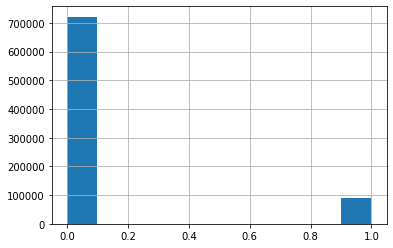

In [25]:
writings_df.label.hist()

In [26]:
writings_df.head()

,date,subject,text,title,subset,label,tokenized_title,title_len,tokenized_text,text_len,...,joy,trust,surprise,anticipation,fear,positive,sadness,disgust,negative,pronouns
0,2014-06-23 14:42:09,train_subject2219,Thing is these are shown on Irish TV before w...,,train,1,[],NaN,"[thing, is, these, are, shown, on, irish, tv, ...",10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2014-06-23 14:39:55,train_subject2219,Spot on,,train,1,[],NaN,"[spot, on]",2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2014-06-23 11:32:11,train_subject2219,All 3 of them...,,train,1,[],NaN,"[all, 3, of, them]",4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,2014-06-23 10:42:56,train_subject2219,"Oh man, I love Rottweilers! They're awesome w...",,train,1,[],NaN,"[oh, man, i, love, rottweilers, they, re, awes...",22.0,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.0,0.090909
4,2014-06-22 21:31:52,train_subject2219,"Another reason why I love the Yogscast. Good,...",,train,1,[],NaN,"[another, reason, why, i, love, the, yogscast,...",12.0,...,0.333333,0.166667,0.083333,0.166667,0.083333,0.416667,0.083333,0.083333,0.0,0.083333


In [27]:
regtokenizer = RegexpTokenizer(r'\w+')
tweet_tokenizer = TweetTokenizer()
sw = stopwords.words("english")

def tokenize(t, tokenizer=regtokenizer):
    return regtokenizer.tokenize(t.lower())

def tokenize_tweets(t, stop=True):
    tokens = tweet_tokenizer.tokenize(t.lower())
    tokens_clean = [re.sub("^#", "", token) for token in tokens]
    tokens_clean = [token for token in tokens_clean 
                            if re.match("^[a-z]*$", token)]
    if not stop:
        tokens_clean = [token for token in tokens
                       if (token not in sw)]
    return tokens_clean
    

In [28]:
# re.sub("^#", "", "#h#ash")

In [29]:
def tokenize_fields(writings_df, tokenize_fct=tokenize, columns=['title', 'text']):
    for c in columns:
        writings_df['tokenized_%s' % c] = writings_df['%s' % c].apply(lambda t: tokenize_fct(t) 
                                                                if type(t)==str and t else None)
        writings_df['%s_len' % c] = writings_df['tokenized_%s' % c].apply(lambda t: len(t) 
                                                                    if type(t)==list and t else None)
    return writings_df

In [30]:
# writings_df = tokenize_fields(writings_df, tokenize_fct=tokenize_tweets, columns=['title'])
# writings_df = tokenize_fields(writings_df, tokenize_fct=tokenize_tweets, columns=['text'])
writings_df = tokenize_fields(writings_df, tokenize_fct=tokenize, columns=['text'])

In [31]:
writings_df.text_len.describe()

count    603403.000000
mean         42.364488
std         131.248600
min           1.000000
25%           8.000000
50%          18.000000
75%          40.000000
max        7471.000000
Name: text_len, dtype: float64

In [32]:
# writings_df.title_len.describe()

In [33]:
writings_df.groupby('subject').mean().describe()

,label,title_len,text_len,ingest,death,adverb,body,number,money,work,...,joy,trust,surprise,anticipation,fear,positive,sadness,disgust,negative,pronouns
count,1304.000000,1284.000000,1302.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,...,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000,1304.000000
mean,0.164110,10.636258,49.916872,0.005033,0.002726,0.043196,0.007766,0.006980,0.007891,0.021144,...,0.024421,0.033824,0.014099,0.025814,0.020818,0.053492,0.016796,0.012884,0.034817,0.037269
std,0.370518,4.121411,88.935839,0.006444,0.002959,0.013896,0.006061,0.003241,0.005979,0.011770,...,0.012403,0.010008,0.008916,0.009352,0.010577,0.015097,0.008358,0.007585,0.013235,0.021059
min,0.000000,1.400000,1.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001472,0.001472,0.000000,0.001786,0.000000,0.007294,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,21.000000,0.001826,0.000955,0.034498,0.003972,0.005205,0.004127,0.013316,...,0.018009,0.028591,0.009820,0.021554,0.014658,0.045869,0.012533,0.008682,0.026887,0.021593
50%,0.000000,10.082790,32.745133,0.003467,0.002078,0.043924,0.006481,0.006781,0.006602,0.018267,...,0.022175,0.032890,0.012408,0.024915,0.019090,0.051711,0.015823,0.011801,0.033296,0.035563
75%,0.000000,12.400000,52.056639,0.005974,0.003680,0.051979,0.009905,0.008615,0.010333,0.026224,...,0.027605,0.037781,0.015503,0.028641,0.024670,0.058294,0.019557,0.015536,0.040746,0.050339
max,1.000000,41.000000,2016.800000,0.084664,0.031507,0.102871,0.063539,0.028346,0.059196,0.111261,...,0.160000,0.124099,0.146667,0.146667,0.125675,0.172621,0.116558,0.100405,0.151969,0.137130


In [34]:
writings_df.groupby('subject').max().groupby('label').count()

,date,text,title,subset,tokenized_title,title_len,tokenized_text,text_len,all_tokens,ingest,...,joy,trust,surprise,anticipation,fear,positive,sadness,disgust,negative,pronouns
label,,,,,,,,,,,,,,,,,,,,,
0,1090,1090,1090,1090,1090,1088,1090,1088,1090,1090,...,1090,1090,1090,1090,1090,1090,1090,1090,1090,1090
1,214,214,214,214,214,196,214,214,214,214,...,214,214,214,214,214,214,214,214,214,214


In [35]:
# print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


Average number of comments per user 622.3819018404907


In [36]:
# writings_df.groupby('subject').count().title.describe()

In [37]:
writings_df.groupby('subject').count().text.describe()

count    1304.000000
mean      622.381902
std       620.157450
min         9.000000
25%        81.750000
50%       365.500000
75%      1097.500000
max      2000.000000
Name: text, dtype: float64

In [38]:
writings_df.tokenized_text.head()

0    [thing, is, these, are, shown, on, irish, tv, ...
1                                           [spot, on]
2                                   [all, 3, of, them]
3    [oh, man, i, love, rottweilers, they, re, awes...
4    [another, reason, why, i, love, the, yogscast,...
Name: tokenized_text, dtype: object

In [39]:
# writings_dict = writings_df.to_dict()
# json.dump(writings_dict, open("writings_df_clpsych_all.json", "w+"))

In [40]:
# print("Total examples", writings_df[['subject', 'subset', 'label'
#                                     ]].groupby('subject').min().groupby('subset').count())
# print("Positive examples", writings_df[['subject', 'subset', 'label'
#                                     ]].groupby('subject').min().groupby('subset').sum())

In [41]:
# writings_df.groupby('subject').sort_values('date').date

# Recurrent NN

## Extract features and encode data

In [35]:
def save_model_and_params(model, model_path, hyperparams, hyperparams_features):
    model.save_weights(model_path + "_weights.h5", save_format='h5')
    model.save_weights(model_path + "_weights")
    model.save(model_path + "_model.model")
    model.save(model_path + "_model.h5")
    with open(model_path + '.hp.json', 'w+') as hpf:
        hpf.write(json.dumps({k:v for (k,v) in hyperparams.items() if k!='optimizer'}))
    with open(model_path + '.hpf.json', 'w+') as hpff:
        hpff.write(json.dumps(hyperparams_features))

In [36]:
def load_params(model_path):
    with open(model_path + '.hp.json', 'r') as hpf:
        hyperparams = json.loads(hpf.read())
    with open(model_path + '.hpf.json', 'r') as hpff:
        hyperparams_features = json.loads(hpff.read())
    return hyperparams, hyperparams_features

In [37]:
hyperparams_features = {
    "max_features": 20002,
    # cut texts after this number of words
    # (among top max_features most common words)
    "embedding_dim": 100,
    'vocabulary_path': 'data/all_vocab_clpsych_erisk_stop_20000.pkl',
#     'embeddings_path': root_dir + '/eRisk/embeddings/finetuned_glove_clpsych_erisk_stop_normalized_20000.pkl',
    'embeddings_path': root_dir + '/resources/glove.840B/glove.840B.300d.txt',
    'liwc_words_cached': 'data/liwc_categories_for_vocabulary_erisk_clpsych_stop_20K.pkl',
    "user_level": True, # deprecated
    "transfer": transfer_type,
    "pretrained_model_path": 'models/lstm_depression_seq30',
}


In [38]:
if transfer_type:
    pretrained_model_path = hyperparams_features['pretrained_model_path']
    hyperparams, hyperparams_features = load_params(hyperparams_features['pretrained_model_path'])
    hyperparams_features['pretrained_model_path'] = pretrained_model_path

### Emotions

In [39]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = root_dir + '/resources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [40]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative and len(tokens):
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

In [41]:
from liwc_readDict import readDict

liwc_dict = {}
for (w, c) in readDict(root_dir + '/resources/liwc.dic'):
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)

categories = set(liwc_dict.keys())
len(categories)

64

In [42]:
liwc_categories=[c for c in categories]# if c in writings_df.columns]

In [43]:
liwc_words_for_categories = pickle.load(open("data/liwc_categories_for_vocabulary_erisk_clpsych_stop_20K.pkl", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/liwc_categories_for_vocabulary_erisk_clpsych_stop_20K.pkl'

### Style features

#### Char n-grams

In [51]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [52]:
first_person_pronouns = {"i", "me", "my", "mine", "myself"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine", "myself"}, relative=True):
    if not tokens:
        return 0
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative and text_len:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [53]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

## BERT


In [54]:
import tensorflow_hub as hub
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
from bert.tokenization import FullTokenizer



ModuleNotFoundError: No module named 'tensorflow_hub'

In [58]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [59]:
def encode_text_for_bert(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

#     if isinstance(example, PaddingInputExample):
#         input_ids = [0] * max_seq_length
#         input_mask = [0] * max_seq_length
#         segment_ids = [0] * max_seq_length
#         label = 0
#         return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label



In [60]:
def create_tokenizer_from_hub_module(sess):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

In [61]:
def initialize_sess(sess=None):
    if not sess:
        sess_config = tf.ConfigProto(
            device_count={ 'GPU' : 1, 'CPU': 4 },
            intra_op_parallelism_threads = 0,
            inter_op_parallelism_threads = 4,
            allow_soft_placement=False,
            log_device_placement=True,
        )
        sess_config.gpu_options.allow_growth = True
        sess_config.gpu_options.per_process_gpu_memory_fraction = 1
        sess = tf.Session(config=sess_config)

    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
    return sess

In [62]:
def load_saved_model(model_path, hyperparams):
    metrics_class = Metrics(threshold=hyperparams['threshold'])
    dependencies = {
    'f1_m': metrics_class.f1_m,
    'auc': metrics_class.auc,
    'precision_m': metrics_class.precision_m,
    'recall_m': metrics_class.recall_m,
    'binary_crossentropy_custom': binary_crossentropy_custom,
    'BertLayer': BertLayer
    }
#     loaded_model = load_model(model_path + "_model.h5", custom_objects=dependencies)
    loaded_model = load_model(model_path + "_model.model", custom_objects=dependencies)
    return loaded_model

In [63]:
tf.test.is_gpu_available()

True

### Encode data

In [64]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = categories, by_subset=True,
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    train_prop=0.7, valid_prop=0.3, test_slice=2,
                    nr_slices=5,
                    min_post_len=3, min_word_len=1, 
                    user_level=True, vocabulary=None,
                   logger=logger):
    logger.debug("Loading data...\n")
    
    ## Build vocabulary
    vocabulary_all = {}
    word_freqs = Counter()
    for words in writings_df.tokenized_text:
        word_freqs.update(words)
    if 'tokenized_title' in writings_df.columns:
        for words in writings_df.tokenized_title:
            word_freqs.update(words)
    i = 1
    for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
        if len(w) < min_word_len:
            continue
        vocabulary_all[w] = i
        i += 1
    if not vocabulary:
        vocabulary = vocabulary_all
    else:
        logger.info("Words not found in the vocabulary: %d\n" % len(set(vocabulary_all.keys()).difference(
            set(vocabulary.keys()))))

   
    if by_subset and 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        logger.info("%d training subjects, %d test subjects\n" % (training_subjects_size, test_subjects_size))
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    categories = [c for c in liwc_categories if c in writings_df.columns]
    logger.debug("%d training users, %d validation users, %d test users." % (
        len(training_subjects), 
          len(valid_subjects),
          len(test_subjects)))
    subjects_split = {'train': training_subjects, 
                      'valid': valid_subjects, 
                      'test': test_subjects}

    user_level_texts = {}
    for row in writings_df.sort_values(by='date').itertuples():
        words = []
        raw_text = ""
        if hasattr(row, 'tokenized_title'):
            if row.tokenized_title:
                words.extend(row.tokenized_title)
                raw_text += row.title
        if hasattr(row, 'tokenized_text'):
            if row.tokenized_text:
                words.extend(row.tokenized_text)
                raw_text += row.text
        if not words or len(words)<min_post_len:
#             logger.debug(row.subject)
            continue
        label = row.label
        liwc_categs = [getattr(row, categ) for categ in categories]
        if row.subject not in user_level_texts.keys():
            user_level_texts[row.subject] = {}
            user_level_texts[row.subject]['texts'] = [words]
            user_level_texts[row.subject]['label'] = label
            user_level_texts[row.subject]['liwc'] = [liwc_categs]
            user_level_texts[row.subject]['raw'] = [raw_text]
        else:
            user_level_texts[row.subject]['texts'].append(words)
            user_level_texts[row.subject]['liwc'].append(liwc_categs)
            user_level_texts[row.subject]['raw'].append(raw_text)
            
    return user_level_texts, subjects_split, vocabulary



In [65]:
vocabulary_list = pickle.load(open(hyperparams_features['vocabulary_path'], 'rb'))
vocabulary_dict={}
for i,w in enumerate(vocabulary_list):
    vocabulary_dict[w] = i
user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
#                                                            vocabulary=pickle.load(open('vocabulary_40K_all.pkl', 'rb')),
#                                                            vocabulary=pickle.load(open('vocab_clpsych_10000.pkl', 'rb')),
#                                                               vocabulary=vocabulary_dict,
                                                              by_subset=False
                                                                               )

FileNotFoundError: [Errno 2] No such file or directory: 'data/all_vocab_clpsych_erisk_stop_20000.pkl'

In [66]:
# writings_df['subset'] = writings_df['subject'].apply(lambda s: 'test' if s in subjects_split['test'] else 'train')

In [67]:
len(vocabulary_dict)

NameError: name 'vocabulary_dict' is not defined

In [68]:
writings_df['tokenized_text'].head()

0    [thing, is, these, are, shown, on, irish, tv, ...
1                                           [spot, on]
2                                   [all, 3, of, them]
3    [oh, man, i, love, rottweilers, they, re, awes...
4    [another, reason, why, i, love, the, yogscast,...
Name: tokenized_text, dtype: object

In [ ]:
writings_df.text_len.hist()

In [ ]:
# pickle.dump(writings_df, open('writings_df_selfharm_liwc_subsets', 'wb+'))

In [ ]:
sorted(vocabulary.items(), key=lambda t:t[1])

In [ ]:
session_collection = {}
models_collection = {}
hyperparams_collection = {}


### Data Generator

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, user_level_data, subjects_split, session=None, use_bert=False, set_type='train',
                 batch_size=32, seq_len=512, vocabulary=vocabulary,
                 voc_size=hyperparams_features['max_features'], emotion_lexicon=nrc_lexicon,
                 hierarchical=False, pad_value=0, padding='pre',
                 post_groups_per_user=None, posts_per_group=10,
                 sampling_distr_alfa=0.1, sampling_distr='exp', # 'exp', 'uniform'
                 emotions=emotions, pronouns=["i", "me", "my", "mine", "myself"], liwc_categories=liwc_categories,
                 liwc_dict=liwc_dict, compute_liwc=False, liwc_words_for_categories=None,
                 pad_with_duplication=False,
                 max_posts_per_user=None, sample_seqs=True,
                 shuffle=True, return_subjects=False):
        'Initialization'
        self.seq_len = seq_len
        # Instantiate tokenizer
        if session:
            self.bert_tokenizer = create_tokenizer_from_hub_module(session)
            session.run(tf.local_variables_initializer())
            session.run(tf.global_variables_initializer())
            session.run(tf.tables_initializer())
        else:
            if use_bert:
                logger.error("Need a session to use bert in data generation")
            self.bert_tokenizer = None
        self.use_bert = use_bert
        self.subjects_split = subjects_split
        self.set = set_type
        self.emotion_lexicon = emotion_lexicon
        self.batch_size = batch_size
        self.hierarchical = hierarchical
        self.data = user_level_data
        self.pad_value = pad_value
        self.return_subjects = return_subjects
        self.sampling_distr_alfa = sampling_distr_alfa
        self.sampling_distr = sampling_distr
        self.emotions = emotions
        self.pronouns = pronouns
        self.liwc_categories = liwc_categories
        self.liwc_dict = liwc_dict
        self.liwc_words_for_categories = liwc_words_for_categories
        self.compute_liwc = compute_liwc
        self.sample_seqs = sample_seqs
        self.pad_with_duplication = pad_with_duplication
        self.padding = padding
        self.shuffle = shuffle
        self.voc_size = voc_size
        self.vocabulary = vocabulary
        self.max_posts_per_user = max_posts_per_user
        self.post_groups_per_user = post_groups_per_user
        self.posts_per_group = posts_per_group
        self.__post_indexes_per_user()
        self.on_epoch_end()
        
    @staticmethod
    def _random_sample(population_size, sample_size, sampling_distr, alfa=0.1, replacement=False):
        if sampling_distr == 'exp':
            # Exponential sampling
            sample = sorted(np.random.choice(population_size, 
                            min(sample_size, population_size),
                            p = DataGenerator.__generate_reverse_exponential_indices(population_size, alfa),
                            replace=replacement))
                                                                # if pad_with_duplication, 
                                                                # pad by adding the same post multiple times
                                                                # if there are not enough posts
        elif sampling_distr == 'uniform':
            # Uniform sampling
            sample = sorted(np.random.choice(population_size,
                            min(sample_size, population_size),
                            replace=replacement))
        return sample
    
    @staticmethod
    def __generate_reverse_exponential_indices(max_index, alfa=1):
        probabilities = []
        for x in range(max_index):
            probabilities.append(alfa * (np.exp(alfa*x)))
        reverse_probabilities = [p for p in probabilities]
        sump = sum(reverse_probabilities)
        normalized_probabilities = [p/sump for p in reverse_probabilities]
        return normalized_probabilities
    
    def __post_indexes_per_user(self):
        self.indexes_per_user = {u: [] for u in range(len(self.subjects_split[self.set]))}
        self.indexes_with_user = []
        for u in range(len(self.subjects_split[self.set])):
            if self.subjects_split[self.set][u] not in self.data:
                logger.warning("User %s has no posts in %s set. Ignoring.\n" % (
                    self.subjects_split[self.set][u], self.set))
                continue
            user_posts = self.data[self.subjects_split[self.set][u]]['texts']
            if self.max_posts_per_user:
                user_posts = user_posts[:self.max_posts_per_user]
            nr_post_groups = int(np.ceil(len(user_posts) / self.posts_per_group))
            
            if self.post_groups_per_user:
                nr_post_groups = min(self.post_groups_per_user, nr_post_groups)
            for i in range(nr_post_groups):
                # Generate random ordered samples of the posts
                if self.sample_seqs:
                    indexes_sample = DataGenerator._random_sample(population_size=len(user_posts),
                                                         sample_size=self.posts_per_group,
                                                         sampling_distr=self.sampling_distr,
                                                         alfa=self.sampling_distr_alfa,
                                                         replacement=self.pad_with_duplication)
                    self.indexes_per_user[u].append(indexes_sample)
                    self.indexes_with_user.append((u, indexes_sample))
                    # break # just generate one?
                # Generate all subsets of the posts in order
                # TODO: Change here if you want a sliding window
                else:
                    self.indexes_per_user[u].append(range(i*self.posts_per_group ,
                                                        min((i+1)*self.posts_per_group, len(user_posts))))
                    self.indexes_with_user.append((u, range(i*self.posts_per_group ,
                                                        min((i+1)*self.posts_per_group, len(user_posts)))))


    def __encode_text(self, tokens, raw_text):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [self.vocabulary.get(w, self.voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, self.emotion_lexicon, self.emotions)
        encoded_pronouns = encode_pronouns(tokens, self.pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        if not self.compute_liwc:
            encoded_liwc = None
        else:
            encoded_liwc = self.__encode_liwc_categories(tokens)
        if self.bert_tokenizer:
            bert_ids, bert_masks, bert_segments, label = encode_text_for_bert(self.bert_tokenizer, InputExample(None, 
                                               raw_text), self.seq_len)
        else:
            bert_ids, bert_masks, bert_segments = [[0]*self.seq_len, [0]*self.seq_len, [0]*self.seq_len]
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc,
               bert_ids, bert_masks, bert_segments)
    
    def __encode_liwc_categories_full(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            category_words = self.liwc_dict[category]
            for t in tokens:
                for word in category_words:
                    if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
                    or (t==word.split("'")[0]):
                        categories_cnt[i] += 1
                        break # one token cannot belong to more than one word in the category
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
        
        
    def __encode_liwc_categories(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            for t in tokens:
                if t in self.liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size)) # + 1 to not discard last batch
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find users
        user_indexes = [t[0] for t in indexes]
        users = set([self.subjects_split[self.set][i] for i in user_indexes
                    if self.subjects_split[self.set][i] in self.data.keys()]) # TODO: maybe needs a warning that user is missing
        post_indexes_per_user = {u: [] for u in users}
        # Sample post ids
        for u, post_indexes in indexes:
            user = self.subjects_split[self.set][u]
            # Note: was bug here - changed it into a list
            post_indexes_per_user[user].append(post_indexes)

        # Generate data
        if self.hierarchical:
            X, s, y = self.__data_generation_hierarchical(users, post_indexes_per_user)
        else:
            X, s, y = self.__data_generation(users, post_indexes_per_user)
        if self.return_subjects:
            return X, s, y
        else:
            return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.indexes_with_user
#         np.arange(len(self.subjects_split[self.set]))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        tokens_data = []
        categ_data = []
        sparse_data = []
        subjects = []
        bert_ids_data = []
        bert_masks_data = []
        bert_segments_data = []
        labels = []
        for subject in users:

            if 'label' in self.data[subject]:
                label = self.data[subject]['label']
            else:
                label = None

            
            all_words = []
            all_raw_texts = []
            liwc_aggreg = []

            for post_index_range in post_indexes[subject]:
                # Sample
                texts = [self.data[subject]['texts'][i] for i in post_index_range]
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_selection = [self.data[subject]['liwc'][i] for i in post_index_range]
                raw_texts = [self.data[subject]['raw'][i] for i in post_index_range]

                all_words.append(sum(texts, [])) # merge all texts in group in one list
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_aggreg.append(np.array(liwc_selection).mean(axis=0).tolist())
                all_raw_texts.append(" ".join(raw_texts))
            for i, words in enumerate(all_words):
                encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc, \
                    bert_ids, bert_masks, bert_segments = self.__encode_text(words, all_raw_texts[i])
                try:
                    subject_id = int(re.findall('[0-9]+', subject)[0])
                except IndexError:
                    subject_id = subject
                tokens_data.append(encoded_tokens)
                # TODO: what will be the difference between these?
                # I think instead of averaging for the post group, it just does it correctly
                # for the whole post group (when computing, non-lazily)
                if 'liwc' in self.data[subject] and not self.compute_liwc:  
                    categ_data.append(encoded_emotions + [encoded_pronouns] + liwc_aggreg[i])
                   
                else:
                    categ_data.append(encoded_emotions + [encoded_pronouns] + encoded_liwc)
                    
                sparse_data.append(encoded_stopwords)
                bert_ids_data.append(bert_ids)
                bert_masks_data.append(bert_masks)
                bert_segments_data.append(bert_segments)
                
                labels.append(label)
                subjects.append(subject_id)

        
        # using zeros for padding
        tokens_data_padded = sequence.pad_sequences(tokens_data, maxlen=self.seq_len, 
                                                    padding=self.padding,
                                                   truncating=self.padding)

        if self.use_bert:
            return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                 np.array(bert_ids_data), np.array(bert_masks_data), np.array(bert_segments_data),
                ],
                np.array(subjects),
                np.array(labels))
        else:
            return ([np.array(tokens_data_padded), np.array(categ_data), np.array(sparse_data),
                ],
                np.array(subjects),
                np.array(labels))
    
    def __data_generation_hierarchical(self, users, post_indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        user_tokens = []
        user_categ_data = []
        user_sparse_data = []
        user_bert_ids_data = []
        user_bert_masks_data = []
        user_bert_segments_data = []
        
        labels = []
        subjects = []
        for subject in users:
             
            all_words = []
            all_raw_texts = []
            liwc_scores = []
            
            if 'label' in self.data[subject]:
                label = self.data[subject]['label']
            else:
                label = None

            for post_index_range in post_indexes[subject]:
                # Sample
                texts = [self.data[subject]['texts'][i] for i in post_index_range]
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_selection = [self.data[subject]['liwc'][i] for i in post_index_range]
                raw_texts = [self.data[subject]['raw'][i] for i in post_index_range]

                all_words.append(texts)
                if 'liwc' in self.data[subject] and not self.compute_liwc:
                    liwc_scores.append(liwc_selection)
                all_raw_texts.append(raw_texts)
            
#             if len(texts) < self.max_posts_per_user:
#                 # TODO: pad with zeros
#                 pass

            for i, words in enumerate(all_words):
                tokens_data = []
                categ_data = []
                sparse_data = []
                bert_ids_data = []
                bert_masks_data = []
                bert_segments_data = []
                
                raw_text = all_raw_texts[i]
                words = all_words[i]
                
                for p, posting in enumerate(words): 
                    encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords, encoded_liwc, \
                        bert_ids, bert_masks, bert_segments = self.__encode_text(words[p], raw_text[p])
                    if 'liwc' in self.data[subject] and not self.compute_liwc:
                        liwc = liwc_scores[i][p]
                    else:
                        liwc = encoded_liwc
                    try:
                        subject_id = int(re.findall('[0-9]+', subject)[0])
                    except IndexError:
                        subject_id = subject
                    tokens_data.append(encoded_tokens)
                    # using zeros for padding
                    # TODO: there is something wrong with this
                    categ_data.append(encoded_emotions + [encoded_pronouns] + liwc)
                    sparse_data.append(encoded_stopwords)
                    bert_ids_data.append(bert_ids)
                    bert_masks_data.append(bert_masks)
                    bert_segments_data.append(bert_segments)
                
                # For each range
                tokens_data_padded = np.array(sequence.pad_sequences(tokens_data, maxlen=self.seq_len,
                                              padding=self.padding,
                                            truncating=self.padding))
                user_tokens.append(tokens_data_padded)

                user_categ_data.append(categ_data)
                user_sparse_data.append(sparse_data)

                user_bert_ids_data.append(bert_ids_data)
                user_bert_masks_data.append(bert_masks_data)
                user_bert_segments_data.append(bert_segments_data)

                labels.append(label)
                subjects.append(subject_id)

        user_tokens = sequence.pad_sequences(user_tokens, 
                                             maxlen=self.posts_per_group, 
                                             value=self.pad_value)
        user_tokens = np.rollaxis(np.dstack(user_tokens), -1)
        user_categ_data = sequence.pad_sequences(user_categ_data,  
                                                 maxlen=self.posts_per_group, 
                                                 value=self.pad_value, dtype='float32')
        user_categ_data = np.rollaxis(np.dstack(user_categ_data), -1)
        
        user_sparse_data = sequence.pad_sequences(user_sparse_data, 
                                                  maxlen=self.posts_per_group, 
                                                  value=self.pad_value)
        user_sparse_data = np.rollaxis(np.dstack(user_sparse_data), -1)
        
        user_bert_ids_data = sequence.pad_sequences(user_bert_ids_data, 
                                                    maxlen=self.posts_per_group, 
                                                    value=self.pad_value)
        user_bert_ids_data = np.rollaxis(np.dstack(user_bert_ids_data), -1)
        
        user_bert_masks_data = sequence.pad_sequences(user_bert_masks_data, 
                                                      maxlen=self.posts_per_group, 
                                                      value=self.pad_value)
        user_bert_masks_data = np.rollaxis(np.dstack(user_bert_masks_data), -1)
        
        user_bert_segments_data = sequence.pad_sequences(user_bert_segments_data, 
                                                         maxlen=self.posts_per_group, 
                                                         value=self.pad_value)
        user_bert_segments_data = np.rollaxis(np.dstack(user_bert_segments_data), -1)
        
        if self.use_bert:
            return ((user_tokens, user_categ_data, user_sparse_data, 
                 user_bert_ids_data, user_bert_masks_data, user_bert_segments_data),
                np.array(subjects),
                np.array(labels))
        else:
            return ((user_tokens, user_categ_data, user_sparse_data), 
                np.array(subjects),
                np.array(labels))

In [ ]:
%%time
logger.setLevel(logging.DEBUG)

# TODO: it is skipping the last batch
x_data = {'train': [], 'valid': [], 'test': []}
y_data = {'train': [], 'valid': [], 'test': []}
for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGenerator(user_level_data, subjects_split, sample_seqs=False, max_posts_per_user=None,
                                          set_type=set_type, hierarchical=True, post_groups_per_user=1,
                              posts_per_group=50, shuffle=False,
                             sampling_distr='exp', liwc_words_for_categories=liwc_words_for_categories,
                             compute_liwc=True):
        total_positive += pd.Series(y).sum()
        x_data[set_type].append(x)
        y_data[set_type].append(y)
        logger.info("%d %s positive examples\n" % (total_positive, set_type))


In [ ]:
%%time
# TODO: it is skipping the last batch
x_data2 = {'train': [], 'valid': [], 'test': []}
y_data2 = {'train': [], 'valid': [], 'test': []}
for set_type in ['train', 'valid', 'test']:
    total_positive = 0
    for x, y in DataGenerator(user_level_data, subjects_split, sample_seqs=False, max_posts_per_user=None,
                                          set_type=set_type, hierarchical=False, post_groups_per_user=1,
                              posts_per_group=50, shuffle=False,
                             sampling_distr='exp', liwc_words_for_categories=liwc_words_for_categories,
                             compute_liwc=False):
        total_positive += pd.Series(y).sum()
        x_data2[set_type].append(x)
        y_data2[set_type].append(y)
        logger.info("%d %s positive examples\n" % (total_positive, set_type))

In [ ]:
x_data['train'][0][1][0]

In [ ]:
x_data2['train'][0][1][0]

In [ ]:
# #x_data['train'][]
# featureindex = 1

# from scipy.stats import pearsonr, spearmanr
# for i in range(len(x_data['train'][0][featureindex])):
#     print(spearmanr(x_data['train'][0][featureindex][i], x_data2['train'][0][featureindex][i]))    
#     plt.scatter(x_data['train'][0][featureindex][i], x_data2['train'][0][featureindex][i])
# #     break


In [ ]:
sum([len(liwc_words_for_categories[c]) for c in categories])
len(categories)
len(set(categories))

In [ ]:
# (x_data['valid'][0][0].shape, x_data['valid'][0][1].shape)

In [ ]:
# encoded_for_bert = encode_text_for_bert(bert_tokenizer, InputExample(None, 
#                                                "Ana are mere"), 200)

In [ ]:
# ids, masks, segments, label = encoded_for_bert

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_data['train']),
#                                                  y_data['train'])
# class_weights

In [ ]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)
    cnt_inv = 0
    f = open(path, encoding='utf8')
    for i, line in enumerate(f):
#         print(i)
        values = line.split()
        word = ''.join(values[:-hyperparams_features['embedding_dim']])
        coefs = np.asarray(values[-hyperparams_features['embedding_dim']:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
            cnt_inv += 1
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))
    print('Words not found in embedding space %d' % (len(embedding_matrix)-cnt_inv))
 
    return embedding_matrix

def load_embeddings2(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) #- 0.5 # voc + unk + pad value(0)
    cnt_inv = 0
    with open(path, "rb") as f:
        embedding_dict = pickle.load(f)
    for word, coefs in embedding_dict.items():
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
            cnt_inv += 1
    print('Total %s word vectors.' % len(embedding_matrix))
    print('Words not found in embedding space %d' % (len(embedding_matrix)-cnt_inv))
 
    return embedding_matrix
# 
# pretrained_embeddings_path = root_dir + '/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
# pretrained_embeddings_path = root_dir + '/resources/glove.840B/glove.840B.%dd.txt' % hyperparams_features['embedding_dim']
pretrained_embeddings_path = hyperparams_features['embeddings_path']#root_dir + '/eRisk/finetuned_glove_clpsych_erisk_normalized_2_20000.pkl'
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], 
                                    voc=vocabulary_dict)


In [ ]:
embedding_matrix.mean()
# hyperparams_features

## Define model

In [ ]:
class Metrics():
    def __init__(self, threshold=0.5):
        self.threshold=threshold
        
    def recall_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            possible_positives = K.sum(K.round(K.clip(y_labels, 0, 1)))
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

    def precision_m(self, y_true, y_pred):
            y_labels = y_true
            y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), self.threshold), K.floatx())        
            true_positives = K.sum(K.round(K.clip(y_labels * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision

    def f1_m(self, y_true, y_pred):
        precision = self.precision_m(y_true, y_pred)
        recall = self.recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    def auc2(self, y_true, y_pred):
#         auc = tf.metrics.auc(y_true, y_pred)[1]
#         K.get_session().run(tf.local_variables_initializer())
        return y_true

    def auc(self, y_true, y_pred):
        has_true_examples = K.greater(K.cast(K.sum(y_true), K.floatx()),0)
        has_false_examples = K.less(K.cast(K.mean(y_true), K.floatx()),1)
        score = tf.cond(tf.logical_and(has_true_examples, has_false_examples), 
                        lambda:tf.py_function(roc_auc_score, (y_true, y_pred), tf.float32), 
                        lambda:0.0)
        return score
        
def binary_crossentropy_custom(y_true, y_pred):
    y_labels = y_true
    return K.binary_crossentropy(y_labels, 
                                 y_pred)



In [ ]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        trainable=True,
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1", 
        **kwargs
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = trainable
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
               "Undefined pooling type (must be either first or mean, but is %s)" % self.pooling
            )

        super(BertLayer, self).__init__(**kwargs)
        
    def get_config(self):

        config = super(BertLayer, self).get_config().copy()
        config.update({
            'n_fine_tune_layers': self.n_fine_tune_layers,
            'trainable': self.trainable,
            'output_size': self.output_size,
            'pooling': self.pooling,
            'bert_path': self.bert_path,
        })

        return config

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name="%s_module" % self.name
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                "Undefined pooling type (must be either first or mean, but is %s)" % self.pooling
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append("encoder/layer_%s" % str(11 - i))

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError("Undefined pooling type (must be either first or mean, but is %s)" % self.pooling)

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [ ]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):
    def attention(xin):
        return K.sum(xin, axis=1) 
    tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
#     if 'batchnorm' not in ignore_layer:
#         embedding_layer_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
#                                                      name='embeddings_layer_norm')(embedding_layer)
    embedding_layer = Dropout(hyperparams['dropout'], name='embedding_dropout')(embedding_layer)

    if 'lstm' not in hyperparams['ignore_layer']:
        if False: #tf.test.is_gpu_available():
            lstm_layers = Bidirectional(CuDNNLSTM(
                            hyperparams['lstm_units'], 
                                    return_sequences='attention' not in hyperparams['ignore_layer'], # only True if using attention
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
        else:
#             lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units'], 
#                                return_sequences='attention' not in ignore_layer,
#                           name='LSTM_layer'), name='bilstm')(embedding_layer)
            lstm_layers = LSTM(hyperparams['lstm_units'], 
                               return_sequences='attention' not in hyperparams['ignore_layer'],
                          name='LSTM_layer')(embedding_layer)
            
    elif 'cnn' not in hyperparams['ignore_layer']:
        cnn_layers = Conv1D(hyperparams['filters'],
                             hyperparams['kernel_size'],
                             padding='valid',
                             activation='relu',
                             strides=1, name='convolution')(embedding_layer)
        # we use max pooling:
        cnn_layers = GlobalMaxPooling1D()(cnn_layers)
    
    # Attention
    if 'attention' not in hyperparams['ignore_layer']:
        attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units']*2)(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)
#         sent_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units'],
#                                         ))(sent_representation)

        
    elif 'lstm' not in hyperparams['ignore_layer']:
        sent_representation = lstm_layers
    elif 'cnn' not in hyperparams['ignore_layer']:
        sent_representation = cnn_layers
    else:
        sent_representation = None
        
    if sent_representation is not None:
        sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
        if hyperparams['dense_sentence_units']:
            sent_representation = Dense(units=hyperparams['dense_sentence_units'], activation='relu',
                                       name='dense_sent_representation')(sent_representation)
    
    # Other features
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords

    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer', activation='relu',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )(sparse_features)
    
    # BERT encoder
    if 'bert_layer' not in hyperparams['ignore_layer']:
        in_id_bert = Input(shape=(hyperparams['maxlen'],), name="input_ids_bert")
        in_mask_bert = Input(shape=(hyperparams['maxlen'],), name="input_masks_bert")
        in_segment_bert = Input(shape=(hyperparams['maxlen'],), name="segment_ids_bert")
        bert_inputs = [in_id_bert, in_mask_bert, in_segment_bert]

        bert_output = BertLayer(n_fine_tune_layers=hyperparams['bert_finetune_layers'], 
                                pooling=hyperparams['bert_pooling'],
                               trainable=hyperparams['bert_trainable'],
                               name='bert_layer')(bert_inputs)
        dense_bert = Dense(hyperparams['bert_dense_units'], activation='relu',
                           kernel_regularizer=regularizers.l2(hyperparams['l2_bert']),
                          name='bert_dense_layer')(bert_output)
    else:
        dense_bert = None


    
    # Batch normalization
    if 'batchnorm' not in hyperparams['ignore_layer']:
        numerical_features_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features)
        sent_representation_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                      name='sent_repr_norm')(sent_representation)
        dense_layer_sparse_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse)
        if 'bert_layer' not in hyperparams['ignore_layer']:
            if hyperparams['bert_dense_units']:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(dense_bert)
            else:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(bert_output)
        else:
            dense_bert_norm = None
        
#     subjects = Input(shape=(1,), name='subjects')
    

    all_layers = {
        'user_encoded': sent_representation,
        'numerical_dense_layer': numerical_features,
        'sparse_feat_dense_layer': dense_layer_sparse,
        'bert_layer': dense_bert if hyperparams['bert_dense_units'] else bert_output,
    }
    if 'batchnorm' not in hyperparams['ignore_layer']:
        all_layers = {
            'user_encoded': sent_representation_norm,
            'numerical_dense_layer': numerical_features_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_norm,
            'bert_layer': dense_bert_norm
        }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in hyperparams['ignore_layer'] or l is None:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                        )(merged_layers)

    # Compile model
    if 'bert_layer' not in hyperparams['ignore_layer']:
        inputs=[tokens_features, numerical_features, sparse_features, 
                              in_id_bert, in_mask_bert, in_segment_bert,
    #                           subjects
                             ]
    else:
        inputs=[tokens_features, numerical_features, sparse_features]
    model = Model(inputs=inputs, outputs=output_layer)
        

    metrics_class = Metrics(threshold=hyperparams['threshold'])
    model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                          metrics_class.auc, 
                           tf.keras.metrics.AUC(name="AUC_keras"), 
                           tf.keras.metrics.FalsePositives(), 
                           tf.keras.metrics.FalseNegatives()])

    return model



In [ ]:
def build_tl_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):
    def attention(xin):
        return K.sum(xin, axis=1) 
    tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=False,
                               name='embeddings_layer')(
        tokens_features)
#     if 'batchnorm' not in ignore_layer:
#         embedding_layer_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
#                                                      name='embeddings_layer_norm')(embedding_layer)
    embedding_layer = Dropout(hyperparams['dropout'], name='embedding_dropout')(embedding_layer)

    if 'lstm' not in ignore_layer:
        if False: #tf.test.is_gpu_available():
            lstm_layers = Bidirectional(CuDNNLSTM(hyperparams['lstm_units'], trainable=False,
                                    return_sequences='attention' not in ignore_layer, # only True if using attention
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
        else:
            lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units'], trainable=False,
                               return_sequences='attention' not in ignore_layer,
                          name='LSTM_layer'), name='bilstm')(embedding_layer)
            
    elif 'cnn' not in ignore_layer:
        cnn_layers = Conv1D(hyperparams['filters'],
                             hyperparams['kernel_size'],
                             padding='valid',
                             activation='relu',
                             strides=1,
                           trainable=False,
                           name='convolution')(embedding_layer)
        # we use max pooling:
        cnn_layers = GlobalMaxPooling1D(trainable=False)(cnn_layers)
    
    # Attention
    if 'attention' not in ignore_layer:
        attention = Dense(1, activation='tanh', name='attention', trainable=False)(lstm_layers)
        attention = Flatten()(attention)
        attention = Activation('softmax')(attention)
        attention = RepeatVector(hyperparams['lstm_units']*2)(attention)
        attention = Permute([2, 1])(attention)

        sent_representation = Multiply()([lstm_layers, attention])
        sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)
#         sent_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units'],
#                                         ))(sent_representation)

        
    elif 'lstm' not in ignore_layer:
        sent_representation = lstm_layers
    elif 'cnn' not in ignore_layer:
        sent_representation = cnn_layers
        
    
    sent_representation = Dropout(hyperparams['dropout'], name='lstm_att_dropout')(sent_representation)
    if hyperparams['dense_sentence_units']:
        sent_representation = Dense(units=hyperparams['dense_sentence_units'], activation='relu',
                                   name='dense_sent_representation',
                                   trainable=False)(sent_representation)
    
    # Other features
    numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input') # emotions and pronouns
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords

    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer', activation='relu',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                               trainable=False,
                              )(sparse_features)
    
    # BERT encoder
    if 'bert_layer' not in hyperparams['ignore_layer']:
        in_id_bert = Input(shape=(hyperparams['maxlen'],), name="input_ids_bert")
        in_mask_bert = Input(shape=(hyperparams['maxlen'],), name="input_masks_bert")
        in_segment_bert = Input(shape=(hyperparams['maxlen'],), name="segment_ids_bert")
        bert_inputs = [in_id_bert, in_mask_bert, in_segment_bert]

        bert_output = BertLayer(n_fine_tune_layers=hyperparams['bert_finetune_layers'], 
                                pooling=hyperparams['bert_pooling'],
                               trainable=False,
                               name='bert_layer')(bert_inputs)
        dense_bert = Dense(hyperparams['bert_dense_units'], activation='relu',
                           kernel_regularizer=regularizers.l2(hyperparams['l2_bert']),
                          name='bert_dense_layer',
                          trainable=False)(bert_output)
    else:
        dense_bert = None


    
    # Batch normalization
    if 'batchnorm' not in ignore_layer:
        numerical_features_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features)
        sent_representation_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                      name='sent_repr_norm')(sent_representation)
        dense_layer_sparse_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse)
        if 'bert_layer' not in hyperparams['ignore_layer']:
            if hyperparams['bert_dense_units']:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(dense_bert)
            else:
                dense_bert_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                         name='bert_layer_norm')(bert_output)
        else:
            dense_bert_norm = None
        
#     subjects = Input(shape=(1,), name='subjects')
    

    all_layers = {
        'user_encoded': sent_representation,
        'numerical_dense_layer': numerical_features,
        'sparse_feat_dense_layer': dense_layer_sparse,
        'bert_layer': dense_bert if hyperparams['bert_dense_units'] else bert_output,
    }
    if 'batchnorm' not in ignore_layer:
        all_layers = {
            'user_encoded': sent_representation_norm,
            'numerical_dense_layer': numerical_features_norm,
            'sparse_feat_dense_layer': dense_layer_sparse_norm,
            'bert_layer': dense_bert_norm
        }
    layers_to_merge = []
    for n, l in all_layers.items():
        if n in ignore_layer:
            continue
        layers_to_merge.append(l)
        
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
        
    TL_layer = Dense(hyperparams['transfer_units'], activation='sigmoid',
                         name='tl_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                         trainable=True
                        )(merged_layers)
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer_tl',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                         trainable=True,
                        )(TL_layer)

    # Compile model
    if 'bert_layer' not in hyperparams['ignore_layer']:
        inputs=[tokens_features, numerical_features, sparse_features, 
                              in_id_bert, in_mask_bert, in_segment_bert,
    #                           subjects
                             ]
    else:
        inputs=[tokens_features, numerical_features, sparse_features]
    model = Model(inputs=inputs, outputs=output_layer)
        

    metrics_class = Metrics(threshold=hyperparams['threshold'])
    model.summary()
    model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                          metrics_class.auc, 
                           tf.keras.metrics.AUC(name="AUC_keras"), 
                           tf.keras.metrics.FalsePositives(), 
                           tf.keras.metrics.FalseNegatives()])

    return model

In [ ]:
def build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
                liwc_categories,
               ignore_layer=[]):
    def attention(xin):
        return K.sum(xin, axis=1) 


    # Post/sentence representation - word sequence
    tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams['maxlen'],
                                embeddings_regularizer=regularizers.l2(hyperparams['l2_embeddings']),
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
    embedding_layer = Dropout(hyperparams['dropout'], name='embedding_dropout')(embedding_layer)

    
    if 'lstm' not in ignore_layer:
        if False: #tf.test.is_gpu_available():
            lstm_layers = CuDNNLSTM(hyperparams['lstm_units'], 
                                    return_sequences='attention' not in ignore_layer, # only True if using attention
                          name='LSTM_layer')(embedding_layer)
        else:
            lstm_layers = LSTM(hyperparams['lstm_units'], 
                               return_sequences='attention' not in ignore_layer,
                          name='LSTM_layer')(embedding_layer)

        # Attention
        if 'attention' not in ignore_layer:
            attention = Dense(1, activation='tanh', name='attention')(lstm_layers)
            attention = Flatten()(attention)
            attention = Activation('softmax')(attention)
            attention = RepeatVector(hyperparams['lstm_units'])(attention)
            attention = Permute([2, 1])(attention)

            sent_representation = Multiply()([lstm_layers, attention])
            sent_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                     output_shape=(hyperparams['lstm_units'],)
                                    )(sent_representation)

#             sent_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units'],
#                                         ))(sent_representation)
        else:
            sent_representation = lstm_layers

    elif 'cnn' not in ignore_layer:
        cnn_layers = Conv1D(hyperparams['filters'],
                             hyperparams['kernel_size'],
                             padding='valid',
                             activation='relu',
                             strides=1)(embedding_layer)
        # we use max pooling:
        sent_representation = GlobalMaxPooling1D()(cnn_layers)
    
    if 'batchnorm' not in ignore_layer:
        sent_representation = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                          name='sent_repr_norm')(sent_representation)
    sent_representation = Dropout(hyperparams['dropout'], name='sent_repr_dropout')(sent_representation)


    # Hierarchy
    sentEncoder = Model(inputs=tokens_features, 
                        outputs=sent_representation)
    sentEncoder.summary()

    posts_history_input = Input(shape=(hyperparams['posts_per_group'], 
                                 hyperparams['maxlen']
                                      ), name='hierarchical_word_seq_input')

    user_encoder = TimeDistributed(sentEncoder, name='user_encoder')(posts_history_input)    
        
    # BERT encoder
    if 'bert_layer' not in hyperparams['ignore_layer']:
        in_id_bert = Input(shape=(hyperparams['maxlen'],), name="input_ids_bert")
        in_mask_bert = Input(shape=(hyperparams['maxlen'],), name="input_masks_bert")
        in_segment_bert = Input(shape=(hyperparams['maxlen'],), name="segment_ids_bert")
        bert_inputs = [in_id_bert, in_mask_bert, in_segment_bert]

        bert_output = BertLayer(n_fine_tune_layers=hyperparams['bert_finetune_layers'], 
                                pooling=hyperparams['bert_pooling'],
                               trainable=hyperparams['bert_trainable'],
                               name='bert_layer')(bert_inputs)
        dense_bert = Dense(hyperparams['bert_dense_units'], 
                           activation='relu',
                          kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                          name='bert_dense_layer')(bert_output)
    
        bertSentEncoder = Model(bert_inputs, dense_bert)


        in_id_bert_history = Input(shape=(hyperparams['posts_per_group'],
                                                          hyperparams['maxlen'],), name="input_ids_bert_hist")
        in_mask_bert_history = Input(shape=(hyperparams['posts_per_group'],
                                                            hyperparams['maxlen'],), name="input_masks_bert_hist")
        in_segment_bert_history = Input(shape=(hyperparams['posts_per_group'],
                                                               hyperparams['maxlen'],), name="segment_ids_bert_hist")
        bert_inputs_history = [in_id_bert_history, in_mask_bert_history, in_segment_bert_history]
        bert_inputs_concatenated = concatenate(bert_inputs_history)
        inputs_indices = [hyperparams['maxlen']*i for i in range(3)]
        # slice the input in equal slices on the last dimension
        bert_encoder_layer = TimeDistributed(Lambda(lambda x: bertSentEncoder([x[:,inputs_indices[0]:inputs_indices[1]], 
                                                                      x[:,inputs_indices[1]:inputs_indices[2]],
                                                                              x[:,inputs_indices[2]:]])),
                                            name='bert_distributed_layer')(
                            bert_inputs_concatenated)
        bertUserEncoder = Model(bert_inputs_history, bert_encoder_layer)
        bertUserEncoder.summary()

        bert_user_encoder = bertUserEncoder(bert_inputs_history)
    else:
        bert_user_encoder = None
    
    # Other features 
    numerical_features_history = Input(shape=(
            hyperparams['posts_per_group'],
            len(emotions) + 1 + len(liwc_categories)
        ), name='numeric_input_hist') # emotions and pronouns
    sparse_features_history = Input(shape=(
            hyperparams['posts_per_group'],
            len(stopwords_list)
        ), name='sparse_input_hist') # stopwords
    
    
    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer', activation='relu',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )
    dense_layer_sparse_user = TimeDistributed(dense_layer_sparse,
                                             name='sparse_dense_layer_user')(sparse_features_history)

    
    # Concatenate features
    if 'batchnorm' not in ignore_layer:
        numerical_features_history_norm = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='numerical_features_norm')(numerical_features_history)
        dense_layer_sparse_user = BatchNormalization(axis=1, momentum=hyperparams['norm_momentum'],
                                                     name='sparse_features_norm')(dense_layer_sparse_user)
    all_layers = {
        'user_encoded': user_encoder,
        'bert_layer': bert_user_encoder,
        'numerical_dense_layer': numerical_features_history if 'batchnorm' in ignore_layer \
                    else numerical_features_history_norm,
        'sparse_feat_dense_layer': dense_layer_sparse_user,
    }
    
    layers_to_merge = [l for n,l in all_layers.items() if n not in ignore_layer]
    if len(layers_to_merge) == 1:
        merged_layers = layers_to_merge[0]
    else:
        merged_layers = concatenate(layers_to_merge)
    
    if 'lstm_user' not in ignore_layer:

        if False:#tf.test.is_gpu_available():
            lstm_user_layers = CuDNNLSTM(hyperparams['lstm_units_user'], 
                                    return_sequences='attention_user' not in ignore_layer, # only True if using attention
                          name='LSTM_layer_user')(merged_layers)
        else:
            lstm_user_layers = LSTM(hyperparams['lstm_units_user'], 
                               return_sequences='attention_user' not in ignore_layer,
                          name='LSTM_layer_user')(merged_layers)

        # Attention
        if 'attention_user' not in ignore_layer:
            attention_user = Dense(1, activation='tanh', name='attention_user')(lstm_user_layers)
            attention_user = Flatten()(attention_user)
            attention_user = Activation('softmax')(attention_user)
            attention_user = RepeatVector(hyperparams['lstm_units_user'])(attention_user)
            attention_user = Permute([2, 1])(attention_user)

            user_representation = Multiply()([lstm_user_layers, attention_user])
            user_representation = Lambda(lambda xin: K.sum(xin, axis=1), 
                                         output_shape=(hyperparams['lstm_units_user'],))(user_representation)
#             user_representation = Lambda(attention, 
#                                          output_shape=(hyperparams['lstm_units_user'],
#                                         ))(user_representation)
        else:
            user_representation = lstm_user_layers
    
    
    elif 'cnn_user' not in ignore_layer:
        cnn_layers_user = Conv1D(hyperparams['filters_user'],
                             hyperparams['kernel_size_user'],
                             padding='valid',
                             activation='relu',
                             strides=1)(merged_layers)
        # we use max pooling:
        user_representation = GlobalMaxPooling1D()(cnn_layers_user)
#         user_representation = Flatten()(user_representation)
    
    
    user_representation = Dropout(hyperparams['dropout'], name='user_repr_dropout')(user_representation)
    
    
    if hyperparams['dense_user_units']:
        user_representation = Dense(units=hyperparams['dense_user_units'], activation='relu',
                                   name='dense_user_representation')(user_representation)
        
    output_layer = Dense(1, activation='sigmoid',
                         name='output_layer',
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense'])
                        )(user_representation)

    # Compile model
    if 'bert_layer' not in hyperparams['ignore_layer']:
        
        hierarchical_model = Model(inputs=[posts_history_input, 
                                       numerical_features_history, sparse_features_history,
                                      in_id_bert_history, in_mask_bert_history, in_segment_bert_history], 
                  outputs=output_layer)
    else:
        hierarchical_model = Model(inputs=[posts_history_input, 
                                       numerical_features_history, sparse_features_history,
                                      ], 
                  outputs=output_layer)
    hierarchical_model.summary()
    
    metrics_class = Metrics(threshold=hyperparams['threshold'])
    hierarchical_model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                          metrics_class.auc])
    return hierarchical_model



In [ ]:
# def build_tl_model(pretrained_model, hyperparams, units=100,  emotions=emotions, stopwords_list=stopword_list,
#                 liwc_categories=liwc_categories):
#     tokens_features = Input(shape=(hyperparams['maxlen'],), name='word_seq_tl')
#     numerical_features = Input(shape=(len(emotions) + 1 + len(liwc_categories),), name='numeric_input_tl') # emotions and pronouns
#     sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input_tl') # stopwords
#     pretrained_model.summary()
#     print("inputs", tokens_features, numerical_features, sparse_features)
#     pretrained_output = pretrained_model(inputs=[tokens_features, numerical_features, sparse_features])
#     # TODO: set trainable to false
#     tl_layer = Dense(units=units, activation='relu',
#                                    name='tl_layer', trainable=False,
#                         kernel_regularizer=regularizers.l2(hyperparams['l2_dense'])
#                     )(pretrained_output)
#     output_layer = Dense(1, activation='sigmoid',
#                          name='tl_output_layer',
#                         kernel_regularizer=regularizers.l2(hyperparams['l2_dense'])
#                         )(tl_layer)
# #     pretrained_model.outputs = output_layer ## I DUNNO
#     tl_model = Model(inputs=[tokens_features, numerical_features, sparse_features], 
#           outputs=output_layer)
#     metrics_class = Metrics(threshold=hyperparams['threshold'])
#     tl_model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
#                   metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
#                           metrics_class.auc, 
#                            tf.keras.metrics.AUC(name="AUC_keras"), 
#                            tf.keras.metrics.FalsePositives(), 
#                            tf.keras.metrics.FalseNegatives()])

#     return tl_model

In [ ]:
# model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories=[c for c in categories if c in writings_df.columns]
# ,
#                    ignore_layer=hyperparams['ignore_layer'])
# model.summary()

In [ ]:
# hierarchical_model = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories=[c for c in categories if c in writings_df.columns]
# ,
#                    ignore_layer=hyperparams['ignore_layer'])

In [ ]:
# plot_model(model, 'models/sequential_bert_model.png')

In [ ]:
# initialize_vars(sess)

In [ ]:
subjects_split

## Train

In [ ]:
class WeightsHistory(callbacks.Callback):
    def __init__(self, logs={}):
        super(WeightsHistory, self).__init__()
    def on_train_begin(self, logs={}):
        self.log_weights(0)
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_weights(epoch)
    def log_weights(self, step):
        for layer in self.model.layers:
            try:
                experiment.log_histogram_3d(layer.get_weights()[0], 
                                            name=layer.name + "_weight", step=step)
            except Exception as e:
#                 logger.debug("Logging weights error: " + layer.name + "; " + str(e) + "\n")
                # Layer probably does not exist
                pass

class OutputsHistory(callbacks.Callback):
    def __init__(self, logs={}, generator=None, generator_type=""):
        super(OutputsHistory, self).__init__()
        self.generator_type = generator_type
        if generator:
            self.generator = generator
        elif generator_type:
            self.generator = DataGenerator(user_level_data, subjects_split, 
                                     set_type=generator_type, 
                                   hierarchical=hyperparams['hierarchical'],
                                seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                     max_posts_per_user=None,
                                   pad_with_duplication=False,
                                    posts_per_group=hyperparams['posts_per_group'],
                                    post_groups_per_user=None, 
                                     sample_seqs=False, shuffle=False)
    def on_train_begin(self, logs={}):
        self.log_outputs(0)
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.log_outputs(epoch)
    def log_outputs(self, step):
        try:
            experiment.log_histogram_3d(self.model.predict(self.generator,  verbose=1, steps=2),
                                        name='output_%s' % self.generator_type, step=step)
        except Exception as e:
            logger.debug("Logging outputs error: " + str(e) + "\n")
#                 Layer probably does not exist
            pass

class LRHistory(callbacks.Callback):
    def __init__(self, logs={}):
        super(LRHistory, self).__init__()
    
    def on_epoch_begin(self, epoch, logs={}):
        self.log_lr()
        
    def log_lr(self):
        lr = K.eval(self.model.optimizer.lr)
        logger.debug("Learning rate is %f...\n" % lr)
        experiment.log_parameter('lr', lr)

class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer={'user_encoder':'embeddings_layer'}, verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        if type(self.freeze_layer)==dict:
            submodel = self.model.get_layer(list(self.freeze_layer.keys())[0])
        else:
            submodel = self.model
        logging.debug("Trainable embeddings", submodel.get_layer(self.freeze_layer).trainable)
        if epoch == self.freeze_epoch:
            try:
                layer = submodel.get_layer(self.freeze_layer)
                old_value = layer.trainable
                layer.trainable = self.set_to
                # TODO: does this reset the optimizer? should I also compile the top-level model?
                self.model.compile(hyperparams['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])
                if self.verbose:
                    logging.debug("Setting %s layer from %s to trainable=%s...\n" % (layer.name, old_value,
                                                                   submodel.get_layer(self.freeze_layer).trainable))
            except Exception as e:
                # layer probably does not exist
                pass

In [ ]:
def train_model(model, hyperparams,
                data_generator_train, data_generator_valid,
                epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                
                model_path='/tmp/model',
                validation_set='valid',
               verbose=1):
    
    logger.info("Initializing callbacks...\n")
    # Initialize callbacks
    freeze_layer = FreezeLayer(patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
    weights_history = WeightsHistory()
    outputs_history_valid = OutputsHistory(generator_type=validation_set)
    outputs_history_train = OutputsHistory(generator_type='train')
    lr_history = LRHistory()

    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                              patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
    lr_schedule = callbacks.LearningRateScheduler(lambda epoch, lr: 
                                                  lr if (epoch+1)%hyperparams['scheduled_reduce_lr_freq']!=0 else
                                                  lr*hyperparams['scheduled_reduce_lr_factor'], verbose=1)
    callbacks_dict = {'freeze_layer': freeze_layer, 'weights_history': weights_history,
           'outputs_history_valid': outputs_history_valid, 'outputs_history_train': outputs_history_train,
           'lr_history': lr_history,
           'reduce_lr_plateau': reduce_lr,
            'lr_schedule': lr_schedule}

    
    logging.info('Train...')


    history = model.fit_generator(data_generator_train,
                steps_per_epoch=100,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=data_generator_valid,
                        verbose=verbose,
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
                callbacks.ModelCheckpoint(filepath='%s_best.h5' % model_path, verbose=1, 
                                          save_best_only=True, save_weights_only=True),
                callbacks.EarlyStopping(patience=hyperparams['early_stopping_patience'],
                                       restore_best_weights=True)] + [
                callbacks_dict[c] for c in [
#                     'weights_history', 
#                     'outputs_history_valid', 'outputs_history_train', 
                    'reduce_lr_plateau', 'lr_schedule'
                ]])
    return model, history

In [ ]:
def get_network_type(hyperparams):
    if 'lstm' in hyperparams['ignore_layer']:
        network_type = 'cnn'
    else:
        network_type = 'lstm'
    if 'user_encoded' in hyperparams['ignore_layer']:
        if 'bert_layer' not in hyperparams['ignore_layer']:
            network_type = 'bert'
        else:
            network_type = 'extfeatures'
    if hyperparams['hierarchical']:
        hierarch_type = 'hierarchical'
    else:
        hierarch_type = 'seq'
    return network_type, hierarch_type

def initialize_experiment(hyperparams, nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                          dataset_type, transfer_type):

    experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                            project_name="mental", workspace="ananana", disabled=False)

    experiment.log_parameters(hyperparams_features)

    experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
    experiment.log_parameter('emotions', emotions)
    experiment.log_parameter('embeddings_path', pretrained_embeddings_path)
    experiment.log_parameter('dataset_type', dataset_type)
    experiment.log_parameter('transfer_type', transfer_type)
    experiment.add_tag(dataset_type)
    experiment.log_parameters(hyperparams)
    network_type, hierarch_type = get_network_type(hyperparams)
    experiment.add_tag(network_type)
    experiment.add_tag(hierarch_type)
    
    return experiment
    

In [ ]:
def initialize_datasets(user_level_data, subjects_split, hyperparams, hyperparams_features, 
                        validation_set, session=None):
    liwc_words_for_categories = pickle.load(open(hyperparams_features['liwc_words_cached'], 'rb'))
    data_generator_train = DataGenerator(user_level_data, subjects_split, set_type='train',
                                        seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                        sample_seqs=hyperparams['sample_seqs'], sampling_distr=hyperparams['sampling_distr'],
                                        posts_per_group=hyperparams['posts_per_group'], post_groups_per_user=hyperparams['post_groups_per_user'],
                                        max_posts_per_user=hyperparams['posts_per_user'], 
                                         hierarchical=hyperparams['hierarchical'], liwc_categories=liwc_categories,
                                         use_bert='bert_layer' not in hyperparams['ignore_layer'],
                                         compute_liwc=True, liwc_words_for_categories=liwc_words_for_categories,
                                        session=session)
    data_generator_valid = DataGenerator(user_level_data, subjects_split, set_type=validation_set,
                                        seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                        posts_per_group=hyperparams['posts_per_group'], 
                                         post_groups_per_user=1,#hyperparams['post_groups_per_user'],
                                        max_posts_per_user=None, liwc_categories=liwc_categories,
                                        sample_seqs=False, shuffle=False, hierarchical=hyperparams['hierarchical'],
                                         use_bert='bert_layer' not in hyperparams['ignore_layer'],
                                         compute_liwc=True, liwc_words_for_categories=liwc_words_for_categories,
                                        session=session)
    return data_generator_train, data_generator_valid

def initialize_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                    liwc_categories, session=None, transfer=False):

    logger.info("Initializing model...\n")
    # Initialize model
    if hyperparams['hierarchical']:
        model = build_hierarchical_model(hyperparams, hyperparams_features, embedding_matrix, 
                                         emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'])
    else:
        model = build_model(hyperparams, hyperparams_features, embedding_matrix, 
                                        emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'])
    if transfer:
        model = build_tl_model(hyperparams, hyperparams_features, embedding_matrix, 
                                        emotions, stopword_list, liwc_categories,
                       ignore_layer=hyperparams['ignore_layer'])
        model.load_weights(hyperparams_features['pretrained_model_path'] + '_weights.h5', by_name=True)
    # Needed just for bert
    if 'bert_layer' not in hyperparams['ignore_layer']:
        initialize_sess(session)                  
    model.summary()
    return model

In [ ]:
def train(user_level_data, subjects_split, 
          hyperparams, hyperparams_features, 
          embedding_matrix, emotions, stopword_list, liwc_categories,
          experiment, validation_set='valid',
          version=0, epochs=50, start_epoch=0,
         session=None, model=None, transfer=False):
    network_type, hierarch_type = get_network_type(hyperparams)
    model_path='models/%s_%s_%s%d' % (network_type, dataset_type, hierarch_type, version)

    logger.info("Initializing datasets...\n")
    data_generator_train, data_generator_valid = initialize_datasets(user_level_data, subjects_split, 
                                                                     hyperparams,hyperparams_features,
                                                                     validation_set=validation_set,
                                                                    session=session)
    if not model:
        if transfer:
            logger.info("Initializing pretrained model...\n")
        else:
            logger.info("Initializing model...\n")
        model = initialize_model(hyperparams, hyperparams_features, embedding_matrix, 
                                 emotions, stopword_list, liwc_categories, session=session, transfer=transfer)

       
    print(model_path)
    logger.info("Training model...\n")
    model, history = train_model(model, hyperparams,
                                 data_generator_train, data_generator_valid,
                       epochs=epochs, start_epoch=start_epoch,
                      class_weight={0:1, 1:hyperparams['positive_class_weight']},
                      callback_list = [
#                           'weights_history',
                          'lr_history',
#                           'outputs_history_valid',
#                           'outputs_history_train',
                          'reduce_lr_plateau',
                          'lr_schedule'
                                      ],
                      model_path=model_path, workers=4,
                                validation_set=validation_set)
    logger.info("Saving model...\n")
    save_model_and_params(model, model_path, hyperparams, hyperparams_features)
    experiment.log_parameter("model_path", model_path)

    return model, history
# except Exception as e:# tf.errors.ResourceExhaustedError:
#     print(e)
#     sess.close()
#     sess = tf.Session(config=sess_config)
#     initialize_vars(sess)


## Train below

In [ ]:
key = 'lstm_seq'
# # non-duplicate key
# while key in models_collection.keys():
#     key=key + "1"
# # models_collection[key] = cur_model
# # session.close()
# session = initialize_sess()
# # all_sessions.append(session)
# session_collection[key] = session


In [ ]:
session_collection

In [ ]:
len(liwc_categories)

In [ ]:
hyperparams = {
    # Network parmeters
    
    # Sequential + hierarchical layers
    'trainable_embeddings': True,

    'lstm_units': 128,
    
    'dense_bow_units': 20,
    'dense_sentence_units': 0,
    
    # CNN
    'filters': 100,
    'kernel_size': 5,
    
    # Just hierarchical layers
    'lstm_units_user': 64,
    'dense_user_units': 0,
    
    'filters_user': 10,
    'kernel_size_user': 3,
        
    # BERT layers
    'bert_dense_units': 256,
    'bert_finetune_layers': 0,
    'bert_trainable': False ,
    'bert_pooling': 'first', # mean, first
    
    'transfer_units': 20,

    # Regularization etc
#     'dropout': 0.2,
    'dropout': 0,
    'l2_dense': 0.00011,
    'l2_embeddings': 0.0000001,
    'l2_bert': 0.0001,
    'norm_momentum': 0.1,
    
    'ignore_layer': [
        'lstm', 'attention', 
#         'cnn',
#         'lstm_user', 'attention_user', 
                     'batchnorm',
#                      'user_encoded', # remove LSTM/CNN
                     'bert_layer',
#                      'numerical_dense_layer', 
#         'sparse_feat_dense_layer' # remove extracted features
                    ],

    # Learning parameters
    'optimizer': None,#'adam',
    'decay': 0.001,
#     'lr': 0.01,
#     'lr': 0.00005,#     'lr': 0.01,
    'lr': 0.01,#     'lr': 0.01,
    "reduce_lr_factor": 0.5,
    "reduce_lr_patience": 55,
    'scheduled_reduce_lr_freq': 95,
    'scheduled_reduce_lr_factor': 0.5,
    "freeze_patience": 2000,
    'threshold': 0.5,
    'early_stopping_patience': 20,
    'positive_class_weight': 5,
#     'positive_class_weight': 2,
    
    # Generator parameters
    
    # Note: average text length in eRisk: 300
    #       average text length in CLPsych: 13
#     "maxlen": 512,
    "maxlen": 256,
    "posts_per_user": None, # if you want to limit total nr of posts considered per user
    "post_groups_per_user": None, # if you want a fixed number of post groups per user
                                  # to even out user weights
    "posts_per_group": 100, # how long are the "batches" of posts. maxlen/avglen~=posts_per_group
    "batch_size": 32,
    "padding": "pre",
    "hierarchical": False,
    'sample_seqs': False,
    'sampling_distr': 'exp',

}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams['decay'])
    
if transfer_type:
    hyperparams, _ = load_params(hyperparams_features['pretrained_model_path'])
    if 'optimizer' not in hyperparams:
        hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                       decay=hyperparams['decay'])

In [43]:

# session_collection['cnn_hierarch'].close()
# K.clear_session()
# transfer_type=None
hyperparams_features

NameError: name 'hyperparams_features' is not defined

In [ ]:
# %%time
transfer_type=None
# with session_collection[key].as_default():
#     with session_collection[key].graph.as_default():
hyperparams_collection[key] = hyperparams


if transfer_type:
    # TODO: try to compile? with proper optimizer?
    hyperparams_collection[key]['trainable_embeddings'] = False
    hyperparams_collection[key]['transfer_units'] = 20
    hyperparams_collection[key]['positive_class_weight'] = 10
    hyperparams_collection[key]['lr'] = 0.0001
    hyperparams_collection[key]['optimizer'] = optimizers.Adam(lr=hyperparams_collection[key]['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
                                   decay=hyperparams_collection[key]['decay'])
#     hyperparams_collection[key]['lr'] = 0.01

#     models_collection[key] = load_saved_model(hyperparams_features['pretrained_model_path'], 
#                                               hyperparams_collection[key])
#     metrics_class = Metrics(threshold=hyperparams_collection[key]['threshold'])
#     models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
#                   metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
#                           metrics_class.auc, 
#                            tf.keras.metrics.AUC(name="AUC_keras"), 
#                            tf.keras.metrics.FalsePositives(), 
#                            tf.keras.metrics.FalseNegatives()])



    experiment = initialize_experiment(hyperparams_collection[key], nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                                  dataset_type, transfer_type)
    models_collection[key], history = train(user_level_data, subjects_split, 
              hyperparams_collection[key], hyperparams_features, 
              embedding_matrix, emotions, stopword_list, liwc_categories,
                  experiment,
                  validation_set='valid',
              version=52, epochs=90, start_epoch=80, transfer=True,
#                     session=session_collection[key],
#                 model=models_collection[key]
                                           )
else:
    experiment = initialize_experiment(hyperparams, nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                          dataset_type, transfer_type)
    models_collection[key], history = train(user_level_data, subjects_split, 
              hyperparams_collection[key], hyperparams_features, 
              embedding_matrix, emotions, stopword_list, liwc_categories,
                  experiment,
                  validation_set='valid',
              version=52, epochs=25, start_epoch=0,
#                     session=session_collection[key],
#                     model=models_collection[key]
                                           )

In [ ]:
# models_collection[key] = initialize_model(hyperparams_collection[key], 
#                                           hyperparams_features, embedding_matrix, emotions, stopword_list,
#                     liwc_categories)
# cur_model.load_weights(model_path + "_weights.h5")
# embedding_matrix.shape
# models_collection[key].load_weights(hyperparams_features['pretrained_model_path'] + "_weights.h5", by_name=True)
# metrics_class = Metrics(threshold=hyperparams_collection[key]['threshold'])
# models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
#               metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
#                       metrics_class.auc, 
#                        tf.keras.metrics.AUC(name="AUC_keras"), 
#                        tf.keras.metrics.FalsePositives(), 
#                        tf.keras.metrics.FalseNegatives()])

In [ ]:
models_collection[key].get_weights()[1]

In [ ]:
models_collection[key].get_weights()[1]

In [ ]:
models_collection[key].summary()

In [ ]:
iterations = 0

# Evaluate on entire posts history, final F1-score
# print("Evaluating on same nr of groups as train (%d)..." % hyperparams['post_groups_per_user'] if 
#       hyperparams['post_groups_per_user'] else 0)
# cur_model.evaluate_generator(DataGenerator(user_level_data, subjects_split, 
#                                          set_type='test', 
#                                     seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
#                                        hierarchical=hyperparams['hierarchical'],
#                                          max_posts_per_user=None,
#                                        pad_with_duplication=False,
#                                         posts_per_group=hyperparams['posts_per_group'],
#                                         post_groups_per_user=hyperparams['post_groups_per_user'], 
#                                          sample_seqs=False, shuffle=False), verbose=1)
# print("Evaluating on entire posts history...")
# cur_model.evaluate_generator(DataGenerator(user_level_data, subjects_split, 
#                                          set_type='test', 
#                                     seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
#                                        hierarchical=hyperparams['hierarchical'],
#                                          max_posts_per_user=None,
#                                        pad_with_duplication=False,
#                                         posts_per_group=hyperparams['posts_per_group'],
#                                         post_groups_per_user=hyperparams['post_groups_per_user'], 
#                                          sample_seqs=False, shuffle=False), verbose=1)
liwc_words_for_categories = pickle.load(open(hyperparams_features['liwc_words_cached'], 'rb'))
# # 
# with session_collection[key].as_default():
#     with session_collection[key].graph.as_default():
print("Evaluating only on last group (1)...")
metrics_class = Metrics(threshold=0.5)
models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
                  metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                          metrics_class.auc, 
                           tf.keras.metrics.AUC(name="AUC_keras"), 
                           tf.keras.metrics.FalsePositives(), 
                           tf.keras.metrics.FalseNegatives()])
results1 = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)
experiment.log_metric("test_f1", results1[1])
experiment.log_metric("test_prec", results1[2])
experiment.log_metric("test_recall", results1[3])
experiment.log_metric("test_auc", results1[4])

# Evaluate on partial post history, simulating stream
print("Evaluating on partial posts history...")
scores_per_iteration = []
for iteration in range(0, iterations, 10):
    print("Iteration", iteration)
    results = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', 
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                        seq_len=hyperparams['maxlen'], 
#                                         batch_size=len(subjects_split['test'])//2, # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                         max_posts_per_user=iteration,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=None, compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)
    scores_per_iteration.append(results[1])

#     Optimal thresh
print("Finding optimal threshold...")
f1s = {}
for thresh in range(0, 10, 2):
    print(thresh)
    # model1.load_weights(model_path + "_weights", by_name=True)
    metrics_class = Metrics(threshold=thresh/10)
    models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
                      metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                            metrics_class.auc, 
                           tf.keras.metrics.AUC(name="AUC_keras"), 
                           tf.keras.metrics.FalsePositives(), 
                           tf.keras.metrics.FalseNegatives()])
    results = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                         set_type='valid', compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,

                                    seq_len=hyperparams_collection[key]['maxlen'], 
                                        batch_size=hyperparams_collection[key]['batch_size'],
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1, 
                                                 sample_seqs=False, shuffle=False), verbose=1)
    f1s[thresh] = results[1]
best_f1 = 0
best_thresh = 0.5
for t, f1 in f1s.items():
    if f1 >= best_f1:
        best_thresh = t
        best_f1 = f1
print(f1s, best_thresh)
hyperparams_features['best_thresh'] = best_thresh/10
experiment.log_metric("best_thresh", best_thresh/10)

print("Computing with best threshold...")
metrics_class = Metrics(best_thresh/10)
models_collection[key].compile(hyperparams_collection[key]['optimizer'], binary_crossentropy_custom,
                      metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m,
                            metrics_class.auc, 
                           tf.keras.metrics.AUC(name="AUC_keras"), 
                           tf.keras.metrics.FalsePositives(), 
                           tf.keras.metrics.FalseNegatives()])
results = models_collection[key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,

                                    seq_len=hyperparams_collection[key]['maxlen'], 
                                        batch_size=hyperparams_collection[key]['batch_size'],
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1, 
                                                 sample_seqs=False, shuffle=False), verbose=1)


In [ ]:
user_level_data2, subjects_split2, vocabulary = load_erisk_data(writings_df[writings_df['source']=='clpsych'], 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
#                                                            vocabulary=pickle.load(open('vocabulary_40K_all.pkl', 'rb')),
#                                                            vocabulary=pickle.load(open('vocab_clpsych_10000.pkl', 'rb')),
                                                              vocabulary=vocabulary_dict,
                                                              by_subset=False
                                                                               )
results2 = models_collection[key].evaluate_generator(DataGenerator(user_level_data2, subjects_split2, 
                                         set_type='test', 
                                    seq_len=hyperparams_collection[key]['maxlen'],   
#                                         batch_size=len(subjects_split['test']), # on all data at once
                                        batch_size=hyperparams_collection[key]['batch_size'], # on all data at once
                                       hierarchical=hyperparams_collection[key]['hierarchical'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[key]['posts_per_group'],
                                        post_groups_per_user=1,  compute_liwc=True,
                                        liwc_words_for_categories=liwc_words_for_categories,
                                         sample_seqs=False, shuffle=False), verbose=1)

In [ ]:
d1, d2 = initialize_datasets(user_level_data, subjects_split, hyperparams, hyperparams_features, 
                        validation_set='valid', session=None)

In [ ]:
for d in d1:
    print(len(d[0][1][0]))
    

In [ ]:
plt.plot(range(0, iterations, 10), scores_per_iteration)

In [ ]:
# save_model_and_params(cur_model, 'models/lstm_selfharm_seq16_2', hyperparams, hyperparams_features)

In [ ]:
# models_collection = {}
# hyperparams_collection = {}


In [ ]:
f1s

In [ ]:
# Stop here
tf.is_gpu_available()

In [ ]:
pd.Series([v for v in model.get_layer('attention_user').get_weights()[0].flatten()])#.rolling(3).mean().plot()

In [ ]:
pd.Series([abs(v) for v in model.get_layer('output_layer').get_weights()[0].flatten()]).plot()

## Cross-validation

In [ ]:
experiment = initialize_experiment(hyperparams, nrc_lexicon_path, emotions, pretrained_embeddings_path, 
                          dataset_type, transfer_type)
experiment.add_tag("cross-validation")

In [ ]:
folds = 5

f1_scores = []
for test_slice in range(folds): 
    logger.info("Testing on slice %d, training on the rest...\n" % test_slice)
    user_level_data, subjects_split, vocabulary = load_erisk_data(writings_df, 
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions,
                                                           user_level=hyperparams_features['user_level'],
                                                                                logger=logger,
                                                           vocabulary=pickle.load(open('all_vocab_clpsych_erisk_2000_dict.pkl', 'rb')),
                                                              by_subset=False,
                                                              nr_slices=folds,
                                                                valid_prop=0.1,
                                                                  test_slice=test_slice
                                                                 )
    model, history = train(user_level_data, subjects_split, 
              hyperparams, hyperparams_features, 
              embedding_matrix, emotions, stopword_list, liwc_categories,
                  experiment,
                validation_set='test',
              version=8, epochs=50,
    )
    f1_scores.append(sum(history.history['val_f1_m'][-6:-1])/5)
experiment.add_metric("average_f1", sum(f1_scores)/5)

## Predict on server data

In [ ]:
# initialize_vars(sess)

In [ ]:
# model_path = "models/lstm_selfharm_seq16"

In [ ]:
hyperparams1, hyperparams_features1 = load_params(model_path)


In [ ]:
# hyperparams_features1['embeddings_path']=[
#     '/home/anasab//eRisk/embeddings/finetuned_glove_clpsych_erisk_stop_20000_2.pkl']

In [ ]:
hyperparams_features1

In [ ]:
loaded_model = load_saved_model(model_path, hyperparams1)


In [ ]:
vocabulary_list = pickle.load(open(hyperparams_features1['vocabulary_path'], 'rb'))
vocabulary_dict={}
for i,w in enumerate(vocabulary_list):
    vocabulary_dict[w] = i
embedding_matrix = load_embeddings2(hyperparams_features1['embeddings_path'], 
                                    hyperparams_features1['embedding_dim'], vocabulary_dict)
liwc_words_for_categories = pickle.load(open(hyperparams_features1['liwc_words_cached'], 'rb'))

In [ ]:
# if 'optimizer' not in hyperparams1:
#         hyperparams1['optimizer'] = optimizers.Adam(lr=hyperparams1['lr'], #beta_1=0.9, beta_2=0.999, epsilon=0.0001,
#                                        decay=hyperparams1['decay'])
# loaded_model = initialize_model(hyperparams1, hyperparams_features1, embedding_matrix, emotions, stopword_list,
#                     liwc_categories)


In [ ]:
loaded_model.load_weights(model_path + "_weights.h5", by_name=True)
# metrics_class = Metrics(threshold=0.5)
# loaded_model.compile(hyperparams1['optimizer'], binary_crossentropy_custom,
#                   metrics=[metrics_class.f1_m, metrics_class.precision_m, metrics_class.recall_m])


### Server data

In [ ]:
models_runs = {
    'bert': 0,
    'lstm_seq': 1,
    'cnn_hierarch': 2,
    'transfer': 3,
    'ensemble': 4,
}

In [ ]:
model_key = 'lstm_seq'

In [ ]:
from collections import Counter
def load_erisk_server_data(datarounds_json, voc_size, emotion_lexicon, tokenizer,
                           liwc_words_for_categories,
                           emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    liwc_categories = liwc_categories, 
                    pronouns = ["i", "me", "my", "mine", "myself"],
                    user_level=True, vocabulary=vocabulary_dict,
                   logger=logger):
    def __encode_liwc_categories(tokens, liwc_words_for_categories, relative=True):
        categories_cnt = [0 for c in liwc_categories]
        if not tokens:
            return categories_cnt
        text_len = len(tokens)
        for i, category in enumerate(liwc_categories):
            for t in tokens:
                if t in liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative and text_len:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt
    logger.debug("Loading data...\n")
     
    subjects_split = {'test': []}
 
    user_level_texts = {}
    for datapoints_json in datarounds_json:
        for datapoint in datapoints_json:
            words = []
            raw_text = ""
            if "title" in datapoint:
                tokenized_title = tokenizer.tokenize(datapoint["title"])
                words.extend(tokenized_title)
                raw_text += datapoint["title"]
            if "content" in datapoint:
                tokenized_text = tokenizer.tokenize(datapoint["content"])
                words.extend(tokenized_text)
                raw_text += datapoint["content"]
            
            liwc_categs = __encode_liwc_categories(words, liwc_words_for_categories)
            if datapoint["nick"] not in user_level_texts.keys():
                user_level_texts[datapoint["nick"]] = {}
                user_level_texts[datapoint["nick"]]['texts'] = [words]
                user_level_texts[datapoint["nick"]]['liwc'] = [liwc_categs]
                user_level_texts[datapoint["nick"]]['raw'] = [raw_text]
                subjects_split['test'].append(datapoint['nick'])
            else:
                user_level_texts[datapoint["nick"]]['texts'].append(words)
                user_level_texts[datapoint["nick"]]['liwc'].append(liwc_categs)
                user_level_texts[datapoint["nick"]]['raw'].append(raw_text)
            
    return user_level_texts, subjects_split, vocabulary

In [ ]:
def read_json_datapoint(jlpath):
    datapoints = []
    with open(jlpath) as f:
        for line in f:
            datapoints.append(json.loads(line))
    return datapoints

In [ ]:
# %%time
# erisk_server_data, erisk_server_subjects_split, vocabulary = load_erisk_server_data(data,
#                        tokenizer=regtokenizer,
#                        liwc_words_for_categories=liwc_words_for_categories,
#                     voc_size=hyperparams_features['max_features'],
#                     emotion_lexicon=nrc_lexicon,
#                     emotions=emotions,
#                     user_level=hyperparams_features['user_level'],
#                        vocabulary=vocabulary_dict,
#     #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
#                     logger=logger)

In [ ]:
erisk_server_data

In [ ]:
%%time
#TODO: predict only on last 50 posts

with session_collection[model_key].as_default():
    with session_collection[model_key].graph.as_default():
        server_erisk_predictions = models_collection[model_key].predict(DataGenerator(erisk_server_data, erisk_server_subjects_split, 
                                             set_type='test', vocabulary=vocabulary_dict, 
                                           hierarchical=hyperparams_collection[model_key]['hierarchical'],
                                        seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                             max_posts_per_user=None,
                                           pad_with_duplication=False,
                                            posts_per_group=hyperparams['posts_per_group'],
                                            post_groups_per_user=None, 
                                             sample_seqs=False, shuffle=False,
                                                    compute_liwc=False)
                                                                       )
        pd.Series(server_erisk_predictions.flatten()).describe()

In [ ]:
pd.Series(server_erisk_predictions.flatten()).describe()

### Seding results to server!

In [ ]:
# subjects = [d['nick'] for d in read_json_datapoint("client/data0.jl")]
# results = {s: 0 for s in subjects}

In [ ]:
# def get_next_data(rnd, results):
#     # TODO: send results to get data
#     response = build_response(results)
#     # Send response
#     data = {"..."}
#     # Make sure it's the correct round
#     assert data['number'] == rnd
#     serialize_data(data)
#     return data

In [ ]:
# def get_next_data_dummy(rnd, results):
#     return read_json_datapoint("client/data0.jl")

In [ ]:
# Results for round and model
results = {key: {} for key in models_runs}

In [ ]:
def get_data_chunk(rnds):
    # Send same results for a chunk of rounds to get new posts
    data = [read_json_datapoint("data_server/data%d.jl" % i) for i in rnds]
#     data_chunks = []
#     for rnd in rnds:
#         # TODO: REPLACE THIS WITH THE CORRECT ONE
#         data = get_next_data_dummy(rnd, results)
#         data_chunks.append(data)
#         all_data[rnd] = data
    return data

In [ ]:
%%time
def predict_for_round_chunk(model, hyperparams, hyperparams_features, vocabulary, data_chunk, subjects=[],
                           model_key='', cache_round=None): 
    # preload for subjects not occurring in the round with results from previous round
#     results = {s: 0 for s in subjects}
    if cache_round:
        results = load_results(model_key, cache_round)
    else:
        results = {s: 0 for s in subjects}
        
    
    erisk_server_data, erisk_server_subjects_split, vocabulary = load_erisk_server_data(data_chunk,
                       tokenizer=regtokenizer,
                       liwc_words_for_categories=liwc_words_for_categories,
                    voc_size=hyperparams_features['max_features'],
                    emotion_lexicon=nrc_lexicon,
                    emotions=emotions,
                    user_level=1,
                       vocabulary=vocabulary,
                    logger=logger)

    for features, subjects, _ in DataGenerator(erisk_server_data, erisk_server_subjects_split, 
                                         set_type='test', vocabulary=vocabulary, 
                                       hierarchical=hyperparams['hierarchical'],
                                    seq_len=hyperparams['maxlen'], batch_size=hyperparams['batch_size'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams['posts_per_group'],
                                        post_groups_per_user=None, 
                                         sample_seqs=False, shuffle=False,
                                      return_subjects=True):
        predictions = model.predict_on_batch(features)
        print(len(features[0]), len(subjects), len(predictions), len(results))
        for i,s in enumerate(subjects):
            results["subject" + str(s)] = predictions[i].item()
    return(results)


In [ ]:
def build_response(results, decision_thresh=0.5, model_name='', rnd=0):
    response = []
    for subject, score in results.items():
        prediction = 1 if score >= decision_thresh else 0
        response.append({'nick': subject, 'score': score, 'decision': prediction})
    json.dump(response, open("data_server/response_run%s_rnd%d.json" % (model_name, rnd), 'w+'))
    return response
# build_response(results, 50000)

In [ ]:
# def get_ensemble_results(rnd, all_results, model_keys_to_average=['lstm_seq', 'cnn_hierarch']):
#     subjects = [s for s in all_results[model_keys_to_average[0]][rnd]]
#     results_ensemble = {}
#     for sub in subjects:
#         s = 0
#         for k in model_keys_to_average:
#             s += all_results[k][rnd][sub]
#         results_ensemble[sub] = s/len(model_keys_to_average)
#     return results_ensemble

In [ ]:
def get_ensemble_results(results_to_average):
    subjects = [s for s in results_to_average[0]]
    results_ensemble = {}
    for sub in subjects:
        s = 0
        for res in results_to_average:
            s += res[sub]
        results_ensemble[sub] = s/len(results_to_average)
    return results_ensemble

In [ ]:
def get_transfer_results(rnd, all_results, model_to_average='lstm_seq', rounds_back=100):
    subjects = [s for s in all_results[model_to_average][rnd]]
    results_ensemble = {}
    for sub in subjects:
        s = 0
        existing_rounds = 0
        for prev_rnd in range(rnd-rounds_back, rnd+1):
#             print("rolling rnds", prev_rnd)
            if prev_rnd in all_results[model_to_average]:
                s += all_results[model_to_average][prev_rnd][sub]
                existing_rounds += 1
        results_ensemble[sub] = s/existing_rounds
#         print("Have found a rolling window of %d for the transfer model" % existing_rounds)
    return results_ensemble

In [ ]:
def load_results(model_key, rnd):
    results = {}
    with open("data_server/response_run%s_rnd%d.json" % (models_runs[model_key], rnd)) as f:
        response = json.loads(f.read())
        for line in response:
            results[line['nick']] = line['score']
    return results

In [ ]:
# results['lstm_seq'][20] = load_results('lstm_seq', 20)
# results['lstm_seq'][40] = 
results# results['bert'][40] = load_results('bert', 40)

In [ ]:
rnds = range(500,600)
decision_thresh = 0.5
data_chunks = get_data_chunk(rnds)
subjects = [d['nick'] for d in read_json_datapoint("data_server/data0.jl")]
# for key in ['transfer', 'ensemble']:
for model_key in [
                  'lstm_seq',
                    'bert',
                  'cnn_hierarch', 
                  'transfer', 
                  'ensemble',
                ]:
    print(model_key)
    end_rnd = rnds[-1]
#     if model_key=='lstm_seq':
#         results[model_key][end_rnd]=load_results('lstm_seq', 20)
    if model_key=='cnn_hierarch':
        results[model_key][end_rnd]=load_results('cnn_hierarch', 40)
    elif model_key=='bert':
        results[model_key][end_rnd]=load_results('bert', end_rnd)
    elif model_key=='ensemble':
        model_keys_to_average=['bert', 'cnn_hierarch', 'lstm_seq']
        missing_models = [m for m in model_keys_to_average if not results[m]]
        if len(missing_models)!=0:
            print("Missing models! cannot compute ensemble results", missing_models)
            continue
        results_to_average = [results[m][end_rnd] for m in model_keys_to_average]
#         results[model_key][end_rnd] = get_ensemble_results(rnd, results, 
#                                                 model_keys_to_average)
        results[model_key][end_rnd] = get_ensemble_results(results_to_average)
    ## For now
    elif model_key=='transfer':
        results[model_key][end_rnd]=get_transfer_results(
            end_rnd, results, model_to_average='lstm_seq', rounds_back=60)
#         results[model_key][end_rnd]=results['lstm_seq'][end_rnd]
    ##
    else:
        with session_collection[model_key].as_default():
            with session_collection[model_key].graph.as_default():
                results[model_key][end_rnd] = predict_for_round_chunk(models_collection[model_key], 
                                              hyperparams_collection[model_key], hyperparams_features, 
                                              vocabulary_dict, 
                                          data_chunks, subjects=subjects, model_key=model_key, cache_round=499)

    
    print(len(results[model_key][end_rnd].values()), "positive:", 
      len([r for r in results[model_key][end_rnd].values() if r >=0.5]))
    response1 = build_response(results[model_key][end_rnd], rnd=end_rnd, 
                               model_name=models_runs[model_key], decision_thresh=decision_thresh)


In [ ]:
results['lstm_seq'].keys()

In [ ]:
pd.Series(list(results['transfer'][180].values())).describe()

In [ ]:
from scipy.stats import pearsonr
pearsonr(list(results['bert'][220].values()), list(results['bert'][180].values()))

In [ ]:
pd.Series(list(results['lstm_seq'][160].values()))

### Predict on eRisk data

In [ ]:
# results = {}
# labels = {}
# featuresall = {}
# with session_collection['lstm_seq2'].as_default():
#     with session_collection['lstm_seq2'].graph.as_default():
        # for features, subjects, lbls in DataGenerator(user_level_data, subjects_split, 
        #                                          set_type='train', vocabulary=vocabulary_dict,
        #                                        hierarchical=hyperparams1['hierarchical'],
        #                                     seq_len=hyperparams1['maxlen'], batch_size=hyperparams1['batch_size'],
        #                                          max_posts_per_user=None,
        #                                        pad_with_duplication=False,
        #                                         posts_per_group=hyperparams1['posts_per_group'],
        #                                         post_groups_per_user=None, 
        #                                          sample_seqs=False, shuffle=False,
        #                                                return_subjects=True):

        #     predictions = loaded_model.predict_on_batch(features)
        #     print(len(features[0]), len(subjects), len(predictions), len(labels), len(results))
        #     for i,s in enumerate(subjects):
        #         if s not in results:
        #             results[s] = []
        #             featuresall[s] = []
        #         results[s].append(predictions[i].item())
        #         featuresall[s].append([features[j][i] for j in range(len(features))])
        #         labels[s] = lbls[i]


In [ ]:
for subject in results:
    if not labels[subject]:
        if np.std(results[subject])>0.0:
            print(subject), print(results[subject][0], results[subject][-1]-results[subject][0])
            pd.Series(results[subject]).rolling(window=5).mean().plot()

In [ ]:
[featuresall[4278][i][0].sum() for i in range(len(featuresall[4278]))]

In [ ]:
len(user_level_data['subject4278']['raw'])

In [ ]:
for x, s, y in DataGenerator(user_level_data, subjects_split, 
                                         set_type='test', vocabulary=vocabulary_dict,
                                       hierarchical=hyperparams1['hierarchical'],
                                    seq_len=hyperparams1['maxlen'], batch_size=hyperparams1['batch_size'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams1['posts_per_group'],
                                        post_groups_per_user=None, 
                                         sample_seqs=False, shuffle=False,
                                               return_subjects=True):
    print("subject", s, "features", x[0].sum(axis=1))
    

In [ ]:
model_key='lstm_seq'
with session_collection[model_key].as_default():
    with session_collection[model_key].graph.as_default():
        res = models_collection[model_key].evaluate_generator(DataGenerator(user_level_data, subjects_split, 
                                              liwc_words_for_categories=liwc_words_for_categories,
                                         set_type='test', vocabulary=vocabulary_dict,
                                       hierarchical=hyperparams_collection[model_key]['hierarchical'],
                                    seq_len=hyperparams_collection[model_key]['maxlen'], 
                                    batch_size=hyperparams['batch_size'],
                                         max_posts_per_user=None,
                                       pad_with_duplication=False,
                                        posts_per_group=hyperparams_collection[model_key]['posts_per_group'],
                                        post_groups_per_user=1,#None, 
                                         sample_seqs=False, shuffle=False,
                                             compute_liwc=False))
        print(res)

In [ ]:
sessions_collection

In [ ]:
# hyperparams_collection['cnn_bert'] = {'hierarchical': False, 'maxlen': 512, 'posts_per_group': 50}

In [ ]:
# hyperparams_collection

###### Feature importance

In [ ]:
features = [
    (e, 'nrc') for e in emotions] + ['pers_pronouns'] + [
    (c, 'liwc') for c in list(categories) if c in writings_df.columns] + [
(st, 'stopword') for st in stopword_list]
weights = model.get_layer('output_layer').get_weights()[0].tolist()[-(len(features)):]

print(len(weights), len(features))
feature_importance = {}
for (i, f) in enumerate(features):
    feature_importance[f] = weights[i][0]

sorted(feature_importance.items(), key=lambda t: abs(t[1]), reverse=True)

## Evaluate per user

In [ ]:
def get_data_for_point(subject, voc, hyperparams_features=hyperparams_features, nrc_lexicon=nrc_lexicon,
                      emotions=emotions):
    eval_writings_df = writings_df[writings_df['subject']==subject]
    correct_label = eval_writings_df.label.values[0]
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(eval_writings_df,
                        seq_len=hyperparams_features['maxlen'],
                        voc_size=hyperparams_features['max_features'],
                        emotion_lexicon=nrc_lexicon,
                        emotions=emotions, user_level=False,
                        train_prop=0.0, vocabulary=voc)
    return x_test, y_test, correct_label

In [ ]:
def predict_per_user(writings_df, majority_prop=0.2, train_prop=0.7, majority_nr=0, validate=False, voc=None,
                    random=False, nr_slices=5, test_slice=2):
    all_predictions = []
    all_labels = []
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    thresh=0.5
    majority_proportion=majority_prop
    valid_prop = 0.3
    
    if 'subset' in writings_df.columns:
        training_subjects = list(set(writings_df[writings_df['subset']=='train'].subject))
        test_subjects = list(set(writings_df[writings_df['subset']=='test'].subject))
    else:
        all_subjects = sorted(list(set(writings_df.subject)))
        training_subjects_size = int(len(all_subjects) * train_prop)
        test_subjects_size = len(all_subjects) - training_subjects_size
        # Cross-validation, with fixed slice as input
        test_prop = 1-train_prop
        test_slice = min(test_slice, nr_slices)
        logger.debug("start index: %f, from %f\n" % (
            len(all_subjects)*(1/nr_slices)*test_slice, test_prop*test_slice))
        start_slice = int(len(all_subjects)*(1/nr_slices)*test_slice)
        test_subjects = all_subjects[start_slice: start_slice+test_subjects_size]
        training_subjects = [s for s in all_subjects if s not in test_subjects]
    training_subjects = sorted(training_subjects) # ensuring reproducibility
    valid_subjects_size = int(len(training_subjects) * valid_prop)
    valid_subjects = training_subjects[:valid_subjects_size]
    training_subjects = training_subjects[valid_subjects_size:]
    
    if validate:
        subjects = valid_subjects
    else:
        subjects = test_subjects
    for subject in subjects:
        x_test_user, y_test_user, label = get_data_for_point(subject, voc=voc)
        outputs = model.predict(x_test_user)
        if random:
            sigma = np.std(outputs)
            mu = np.mean(outputs)
            print("generating random outputs with sigma", sigma, "and mu", mu)
            outputs = sigma*np.random.randn(len(outputs))+mu
        positive_pred = sum(outputs>=thresh)
        negative_pred = sum(outputs<thresh)
        majority_pred = 0
        if majority_proportion and positive_pred >= majority_proportion*negative_pred:
            majority_pred = 1
        if majority_nr and positive_pred>=majority_nr:
            majority_pred = 1
        if label == 1:
            if majority_pred == 1:
                tp+=1
            else:
                fn+=1
        else:
            if majority_pred == 0:
                tn+=1
            else:
                fp+=1
        print(negative_pred, positive_pred, majority_pred)
        all_predictions.append(majority_pred)
        all_labels.append(label)
    def prec_recall_f1(tp, fp, tn, fn):
        recall = tp/(tp+fn+0.0000001)
        precision = tp/(tp+fp+0.0000001)
        f1 = 2*precision*recall/(precision+recall+0.0000001)
        print("Recall", recall, "Precision", precision, "F1", f1)
    if majority_prop:
        print("Vote proportion", majority_prop)
    if majority_nr:
        print("Vote points", majority_nr)
    prec_recall_f1(tp, fp, tn, fn)

        

In [ ]:
predict_per_user(writings_df=writings_df, voc=voc, majority_prop=0.2)

## Cross-validation

In [ ]:
results_per_slice = {}

In [ ]:
nr_slices=5
logger.setLevel(logging.INFO)
for tslice in range(nr_slices): 
    (x_train, y_train), (x_valid, y_valid), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                                seq_len=hyperparams_features['maxlen'],
                                                                voc_size=hyperparams_features['max_features'],
                                                               emotion_lexicon=nrc_lexicon,
                                                               emotions=emotions,
                                                               user_level=hyperparams_features['user_level'],
                                                                                    test_slice=tslice,
                                                                                    nr_slices=nr_slices,
    #                                                            vocabulary=pickle.load(open('vocabulary20K_selfharm.pkl', 'rb'))
                                                                                   logger=logger)
    model, history = train_model(model, x_train, y_train, x_valid, y_valid,
           epochs=200, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:5}, start_epoch=0,
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      workers=2, verbose=0)
    results_per_slice[tslice] = model.evaluate(x_test, y_test)
    logger.info("Results for slice %d: %s\n" % (tslice, results_per_slice[tslice]))

In [ ]:
print("Average F1 score: ", np.array([results_per_slice[s][1] for s in results_per_slice.keys()]).mean(),
     "all F1 scores: ", {s: v[1] for (s,v) in results_per_slice.items()} )

## Extra analysis


In [55]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [56]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative and len(tokens):
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [57]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [58]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

,label,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.141548,0.001767,-0.018706,-0.001991,-0.000641,-0.029771,0.015376,-0.020250,-0.004770,-0.002814,-0.017061,-0.008363
pronouns,0.141548,1.000000,0.009578,-0.046744,-0.023335,-0.023392,-0.063543,0.006837,-0.063402,-0.028198,-0.030865,-0.027233,-0.029973
text_len,0.001767,0.009578,1.000000,-0.009253,-0.011282,-0.014849,-0.002235,-0.024045,-0.007351,-0.016108,-0.001069,-0.013683,-0.011317
anger,-0.018706,-0.046744,-0.009253,1.000000,0.079270,0.538836,0.573363,0.027015,0.632087,0.022286,0.464580,0.163645,0.036400
anticipation,-0.001991,-0.023335,-0.011282,0.079270,1.000000,0.046367,0.118551,0.593373,0.059835,0.456859,0.080516,0.475230,0.456102
disgust,-0.000641,-0.023392,-0.014849,0.538836,0.046367,1.000000,0.383289,0.023484,0.570610,0.014141,0.423732,0.110992,0.023565
fear,-0.029771,-0.063543,-0.002235,0.573363,0.118551,0.383289,1.000000,0.027865,0.577988,0.036232,0.527490,0.140559,0.063541
joy,0.015376,0.006837,-0.024045,0.027015,0.593373,0.023484,0.027865,1.000000,-0.012048,0.685398,0.049961,0.462737,0.589400
negative,-0.020250,-0.063402,-0.007351,0.632087,0.059835,0.570610,0.577988,-0.012048,1.000000,-0.013037,0.581562,0.127099,0.007170
positive,-0.004770,-0.028198,-0.016108,0.022286,0.456859,0.014141,0.036232,0.685398,-0.013037,1.000000,0.029600,0.330997,0.647792


In [63]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'subject'] + emotions].groupby('subject').mean().corr()

,label,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.466827,0.017641,-0.104687,-0.014279,-0.045834,-0.139488,0.029806,-0.102315,-0.056676,-0.002080,-0.109270,-0.020131
pronouns,0.466827,1.000000,0.143079,-0.241525,-0.064173,-0.063054,-0.338177,0.073155,-0.295912,-0.138638,-0.102741,-0.187297,-0.120777
text_len,0.017641,0.143079,1.000000,-0.034923,-0.067237,-0.022241,-0.066312,-0.104094,-0.068714,-0.106308,-0.041583,-0.070508,-0.103088
anger,-0.104687,-0.241525,-0.034923,1.000000,0.063304,0.559546,0.782360,-0.007202,0.730543,0.069692,0.513875,0.243803,0.208935
anticipation,-0.014279,-0.064173,-0.067237,0.063304,1.000000,0.079474,0.053420,0.657685,0.070433,0.634664,0.176743,0.591110,0.601632
disgust,-0.045834,-0.063054,-0.022241,0.559546,0.079474,1.000000,0.439077,0.113387,0.665141,0.057294,0.432380,0.196867,0.095206
fear,-0.139488,-0.338177,-0.066312,0.782360,0.053420,0.439077,1.000000,-0.074427,0.690689,0.039081,0.522041,0.187633,0.178849
joy,0.029806,0.073155,-0.104094,-0.007202,0.657685,0.113387,-0.074427,1.000000,-0.017230,0.792108,0.098208,0.551726,0.496315
negative,-0.102315,-0.295912,-0.068714,0.730543,0.070433,0.665141,0.690689,-0.017230,1.000000,0.081112,0.698466,0.226197,0.203600
positive,-0.056676,-0.138638,-0.106308,0.069692,0.634664,0.057294,0.039081,0.792108,0.081112,1.000000,0.119927,0.518270,0.662197


In [59]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,
0,0.027455,42.271740,0.018265,0.025429,0.012754,0.022802,0.02193,0.036955,0.052819,0.017002,0.014242,0.034492
1,0.052482,42.944565,0.015202,0.025060,0.012661,0.017507,0.02493,0.032309,0.051519,0.016573,0.011768,0.032667


In [ ]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [ ]:
sid = SentimentIntensityAnalyzer()


In [ ]:
sid.polarity_scores("We are here today happiness is all around")

In [ ]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [ ]:
writings_df

In [ ]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

In [ ]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

### Timeline of diagnosis?

In [69]:
depressed_users = set(writings_df[writings_df['label']==1].subject)

In [70]:
writings_df[writings_df['subject']=='subject12570000']

,date,subject,text,title,subset,label,tokenized_title,title_len,tokenized_text,text_len,...,joy,trust,surprise,anticipation,fear,positive,sadness,disgust,negative,pronouns
53633,2017-01-25 14:05:43,subject12570000,"Ugh, CD1, I'll be following you very shortly ...",,test,1,[],NaN,"[ugh, cd1, i, ll, be, following, you, very, sh...",30.0,...,0.033333,0.033333,0.000000,0.066667,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333
53634,2017-01-25 14:04:43,subject12570000,15DPO. .5 degree temp drop. Mild Cramps. Look...,,test,1,[],NaN,"[15dpo, 5, degree, temp, drop, mild, cramps, l...",81.0,...,0.012346,0.012346,0.012346,0.037037,0.000000,0.024691,0.000000,0.012346,0.000000,0.086420
53635,2017-01-25 14:01:19,subject12570000,Temp drop of .5 degrees this morning with lig...,,test,1,[],NaN,"[temp, drop, of, 5, degrees, this, morning, wi...",15.0,...,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
53636,2017-01-25 02:11:30,subject12570000,"No AF, and I couldn't bring myself to test th...",,test,1,[],NaN,"[no, af, and, i, couldn, t, bring, myself, to,...",34.0,...,0.000000,0.029412,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.147059
53637,2017-01-24 17:37:53,subject12570000,I've got such a pretty chart after I ovulated...,,test,1,[],NaN,"[i, ve, got, such, a, pretty, chart, after, i,...",52.0,...,0.038462,0.096154,0.000000,0.038462,0.019231,0.057692,0.019231,0.019231,0.019231,0.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514620,2017-04-12 17:06:01,subject12570000,"Yes, have that wine or beer or whatever!! On ...",,test,1,[],NaN,"[yes, have, that, wine, or, beer, or, whatever...",82.0,...,0.036585,0.024390,0.024390,0.024390,0.024390,0.048780,0.024390,0.012195,0.024390,0.073171
514621,2017-04-12 17:03:17,subject12570000,"I can't believe I'm still here, waiting for t...",,test,1,[],NaN,"[i, can, t, believe, i, m, still, here, waitin...",82.0,...,0.012195,0.024390,0.012195,0.024390,0.000000,0.024390,0.000000,0.012195,0.012195,0.109756
514622,2017-04-12 17:00:53,subject12570000,Thanks!!,,test,1,[],NaN,[thanks],1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
514623,2017-04-12 16:43:20,subject12570000,I just want to wish you good luck!! I think y...,,test,1,[],NaN,"[i, just, want, to, wish, you, good, luck, i, ...",158.0,...,0.012658,0.025316,0.025316,0.018987,0.000000,0.037975,0.006329,0.000000,0.006329,0.101266


In [73]:
from collections import Counter
for user in depressed_users:
    user_vocab = Counter(sum(writings_df[writings_df['subject']==user].tokenized_text.values, []))
    print(user_vocab['diagnosed'], user_vocab['diagnosis'], user_vocab['diagnose'])

0 1 0
0 1 1
7 1 0
2 0 0
2 0 0
3 2 0
8 1 0
0 0 0
5 5 0
7 5 0
0 0 0
2 5 1
1 0 0
1 0 1
0 0 0
0 0 0
3 1 0
1 3 0
2 0 0
0 0 0
0 0 1
0 0 0
0 0 0
0 0 0
11 14 0
16 22 1
0 0 0
0 1 0
2 2 0
0 0 0
11 2 1
2 2 0
2 0 0
0 0 0
1 0 0
6 0 0
1 0 0
0 0 0
1 0 0
0 0 0
1 1 0
1 1 0
2 0 0
1 0 0
0 0 0
0 0 0
0 0 0
1 0 0
0 0 0
2 0 0
5 5 6
0 0 0
0 0 0
8 0 0
0 0 0
0 0 0
0 0 0
14 11 2
1 0 0
0 1 0
2 0 0
1 0 0
0 0 0
0 0 0
1 0 0
1 0 0
1 0 0
5 2 0
0 0 0
0 0 0
1 0 0
18 9 0
2 0 0
1 0 0
0 0 0
2 8 0
0 0 0
0 0 0
1 0 0
0 0 0
0 0 0
1 0 1
0 0 0
1 0 0
3 0 0
0 0 0
3 0 0
0 0 0
1 0 0
0 0 0
0 0 0
2 0 1
0 0 0
0 1 0
0 0 0
3 0 0
0 0 0
0 0 0
5 0 1
0 0 0
2 1 0
2 0 0
0 0 0
1 0 0
0 0 0
0 0 0
1 0 0
0 0 0
0 0 0
3 1 0
9 0 0
0 0 0
1 0 0
0 0 0
0 2 0
0 0 0
0 0 0
3 1 0
5 0 0
6 1 0
5 1 1
0 0 0
3 1 0
0 0 0
19 15 0
1 1 0
0 0 0
3 2 1
0 0 0
0 0 0
1 0 0
1 0 0
3 0 0
2 0 0
2 1 0
0 0 0
9 1 0
0 0 0
0 0 0
0 0 0
0 0 0
4 3 0
0 0 0
0 0 0
3 0 0
0 1 0
0 0 0
3 0 0
0 1 1
3 5 0
1 0 0
0 0 0
1 0 0
0 0 0
0 0 0
0 0 0
11 0 0
0 0 0
7 1 0
0 0 0
3 0 0
7 0 1
0 0 0
0 0 0
0 0 0

In [89]:
def mentions(tokenized_text, terms=['diagnosis', 'diagnosed', 'diagnose']):
    for term in terms:
        if term in tokenized_text:
            return True
    return False

writings_df['diagnosis'] = writings_df['tokenized_text'].apply(mentions)
writings_df['depression_mention'] = writings_df['tokenized_text'].apply(lambda t: 
                                                                        mentions(t, ['depressed', 'depression']))

In [90]:
pd.set_option('display.max_rows', 214)

In [93]:
writings_df[writings_df['label']==1].groupby('subject').sum()[['label', 'diagnosis', 'depression_mention']
                                                             ].groupby()

,label,diagnosis,depression_mention
subject,,,
subject12570000,839,839,839
subject12600000,1960,1960,1960
subject13340000,434,434,434
subject1360000,17,17,17
subject14100000,1553,1553,1553
subject14860000,126,126,126
subject1880000,25,25,25
subject19630000,1126,1126,1126
subject21630000,91,91,91


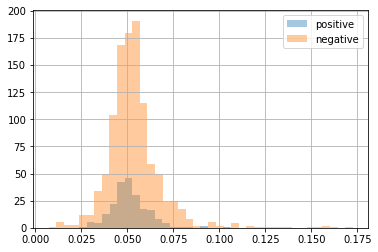

In [119]:
feature = 'positive'
writings_df[writings_df['label']==1].groupby('subject').mean()[feature].hist(bins=20, alpha=0.4, label='positive')
writings_df[writings_df['label']==0].groupby('subject').mean()[feature].hist(bins=40, alpha=0.4, label='negative')
plt.legend()

### LIWC

In [60]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic'

In [61]:
categories = [c for (w,c) in liwc]
set(categories)

NameError: name 'liwc' is not defined

In [ ]:
liwc

In [ ]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)

    
    

In [ ]:
liwc_dict['pronoun']

In [ ]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [ ]:
    def __encode_liwc_categories(self, tokens, relative=True):
        categories_cnt = [0 for c in self.liwc_categories]
        if not tokens:
            return None
        text_len = len(tokens)
        for i, category in enumerate(self.liwc_categories):
            for t in tokens:
                print("token", t)
                if t in self.liwc_words_for_categories[category]:
                    categories_cnt[i] += 1
            if relative:
                categories_cnt[i] = categories_cnt[i]/text_len
        return categories_cnt

In [ ]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


In [ ]:
%%time
# categories for all words in vocabulary
# vocabulary = pickle.load(open("all_vocab_clpsych_erisk_50000.pkl", "rb"))
liwc_words_for_categories = {}
for categ in liwc_dict.keys():
    liwc_words_for_categories[categ] = set()
    for word in liwc_dict[categ]:
        for t in vocabulary:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
                or (t==word.split("'")[0]):
                    liwc_words_for_categories[categ].add(t)

In [ ]:
pickle.dump(liwc_words_for_categories, open("data/liwc_categories_for_vocabulary_erisk_clpsych_stop_40K.pkl", "wb+"))

In [ ]:
writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

In [ ]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

In [ ]:
writings_df.groupby('subject').mean()[['label'] + categories].corr()

## Hyperparameter tuning

In [ ]:
# Declare your hyperparameters search:
tune_epochs=150
config = {
      "algorithm": "bayes",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 32, "max": 300},
          "lstm_units_user": {"type": "integer", "min": 5, "max": 40},
          "dense_bow_units": {"type": "integer", "min": 5, "max": 35},
          "filters": {"type": "integer", "min": 30, "max": 250},
          "kernel_size": {"type": "integer", "min": 3, "max": 7},
          "dense_sentence_units": {"type": "integer", "min": 0, "max": 10},
          "dense_user_units": {"type": "integer", "min": 0, "max": 0},
          "bert_dense_units": {"type": "integer", "min": 10, "max": 200},
          "bert_finetune_layers": {"type": "integer", "min": 0, "max": 2},
          "lr": {"type": "float", "min": 0.0005, "max": 0.2, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.0000001, "max": 0.1, "scalingType": "loguniform"},
          "l2_embeddings": {"type": "float", "min": 0.00000001, "max": 0.2, "scalingType": "loguniform"},
          "l2_bert": {"type": "float", "min": 0.00000001, "max": 0.2, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.5, "scalingType": "uniform"},
          "norm_momentum": {"type": "float", "min": 0, "max": 0.99, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": [""]},#"adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 5, "max": 128, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 3, "max": 10},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
          "sample_seqs": {"type": "discrete", "values": [True, False]},
          "bert_trainable": {"type": "discrete", "values": [True, False]},
          "bert_pooling": {"type": "categorical", "values": ['first', 'mean']},
#           "hierarchical": {"type": "discrete", "values": [True, False]},
          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "scheduled_lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "scheduled_lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "early_stopping_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},
#           "ignore_layers_values": {"type": "categorical", "values": ["attention", "batchnorm", "bert_layer"]},
          "sampling_distr": {"type": "categorical", "values": ["exp", "uniform"]},
          "posts_per_group": {"type": "integer", "min": 10, "max": 100},
          "post_groups_per_user": {"type": "integer", "min": 1, "max": 50},
#           "posts_per_user": {"type": "integer", "min": 0, "max": 1000},
          "maxlen": {"type": "integer", "min":64, "max": 512},
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

hyperparams_config = hyperparams

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    experiment.add_tag(dataset_type)
    
    print(hyperparams_config)
    

    data_generator_train = DataGenerator(user_level_data, subjects_split, set_type='train',
                                         seq_len=hyperparams_config["maxlen"],
                                                     sample_seqs=hyperparams_config['sample_seqs'],
                                                     sampling_distr=hyperparams_config['sampling_distr'],
                                                    posts_per_group=hyperparams_config['posts_per_group'],
                                                    post_groups_per_user=1,#hyperparams_config['post_groups_per_user'],
                                                    max_posts_per_user=hyperparams_config['posts_per_user'],
                                    hierarchical=hyperparams['hierarchical'])
    data_generator_valid = DataGenerator(user_level_data, subjects_split, set_type='valid',
                                         seq_len=hyperparams_config["maxlen"],
                                         
                                                    posts_per_group=hyperparams_config['posts_per_group'],
                                                    post_groups_per_user=hyperparams_config['post_groups_per_user'],
                                                    max_posts_per_user=None,
                                                    sample_seqs=False, 
                                                     shuffle=False,
                                                hierarchical=hyperparams['hierarchical'])
    try:
        if hyperparams['hierarchical']:
            model = build_hierarchical_model(hyperparams_config, hyperparams_features, embedding_matrix, emotions, stopword_list,
                            liwc_categories=[c for c in categories if c in writings_df.columns]
        ,
                           ignore_layer=hyperparams_config['ignore_layer'])
        else:
            model = build_model(hyperparams_config, hyperparams_features, embedding_matrix, emotions, stopword_list,
                            liwc_categories=[c for c in categories if c in writings_df.columns]
        ,
                           ignore_layer=hyperparams_config['ignore_layer'])
        model.summary()

        freeze_layer = FreezeLayer(model, patience=hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
        weights_history = WeightsHistory()
        lr_history = LRHistory()
        reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                                  patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)
        lr_schedule = callbacks.LearningRateScheduler(lambda epoch, lr: 
                                                      lr if (epoch+1)%hyperparams['scheduled_reduce_lr_freq']!=0 else
                                                      lr*hyperparams['scheduled_reduce_lr_factor'], verbose=1)

        model, history = train_model(model, hyperparams, data_generator_train, data_generator_valid,
                           epochs=tune_epochs,
                          class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, 
                                     start_epoch=0,
                          callback_list = [
    #                                  weights_history, 
                                           reduce_lr, 
    #                                        lr_history, 
                                           lr_schedule
                                          ],
                          model_path='models/experiment', workers=4)
    except tf.errors.ResourceExhaustedError as e:
        print(e)
        sess.close()
        sess = tf.Session(config=sess_config)
        initialize_vars(sess)

    
    loss = history.history['loss'][-1]
    
    
    # Test the model
    for param in config['parameters'].keys():    
        hyperparams_config[param] = experiment.get_parameter(param)
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
#     hyperparams_config["ignore_layer"] = []
#     if hyperparams_config["ignore_layers_values"]:
#         hyperparams_config["ignore_layer"] = [hyperparams_config["ignore_layers_values"]]
    hyperparams_config["ignore_layer"] = ["bert_layer", "batchnorm"]
        
#     freeze_layer = FreezeLayer(model, patience=experiment.get_parameter('freeze_patience'),
#                               set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.00000001, verbose=1)
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)